# Survey data 

Analysis after (phase 2) data collection completed.

Using survey data only (no Amazon data)

- Analysis for behavior experiments
    - what impacts sharing behavior?
        - how does share rate differ by experiment arm?
        - how does share rate differ by demographic group?
        - and more...
    - what is the difference between how real monetary bonuses impact sharing vs hypothetical monetary bonuses?
- Analysis for other survey questions

Also check:

- Data validation: is the number of completions consistent across experiment arms?
- Overall share rate

In [1]:
import re

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import chisquare
import statsmodels.api as sm
import statsmodels.formula.api as smf

data_filepath = '../data/survey-data/survey.csv'
fields_filepath = '../data/survey-data/fields.csv'

### Reading in data and minor transforms

In [2]:
# Reminder: Here are the fields
fields_df = pd.read_csv(fields_filepath, index_col=0)
fields_df

,fields
Duration (in seconds),Duration (in seconds)
RecordedDate,Recorded Date
ResponseId,Response ID
Q-prolific,What is your Prolific ID?
Q-prolific-mturk,Do you also complete surveys (or HITs) using A...
q-demos-age,What is your age group?
Q-demos-hispanic,"Are you of Spanish, Hispanic, or Latino origin?"
Q-demos-race,Choose one or more races that you consider you...
Q-demos-education,What is the highest level of education you hav...
Q-demos-income,What was your total household income before ta...


In [3]:
df = pd.read_csv(data_filepath)
print('shape:', df.shape)
print('all fields:', df.columns)
df.head(2)

shape: (6325, 41)
all fields: Index(['Duration (in seconds)', 'RecordedDate', 'ResponseId',
       'Q-prolific-mturk', 'q-demos-age', 'Q-demos-hispanic', 'Q-demos-race',
       'Q-demos-education', 'Q-demos-income', 'Q-demos-gender',
       'Q-sexual-orientation', 'Q-demos-state', 'Q-amazon-use-howmany',
       'Q-amazon-use-hh-size', 'Q-amazon-use-how-oft', 'Q-substance-use_1',
       'Q-substance-use_2', 'Q-substance-use_3', 'Q-personal_1',
       'Q-personal_2', 'Q-life-changes', 'Q-control', 'Q-altruism',
       'Q-bonus-05', 'Q-bonus-20', 'Q-bonus-50', 'Q-data-value-05',
       'Q-data-value-20', 'Q-data-value-50', 'Q-data-value-100',
       'Q-data-value-any', 'Q-data-value-any_1_TEXT', 'Q-sell-YOUR-data',
       'Q-sell-consumer-data', 'Q-small-biz-use', 'Q-census-use',
       'Q-research-society', 'Q-attn-check', 'showdata', 'incentive',
       'connect'],
      dtype='object')


,Duration (in seconds),RecordedDate,ResponseId,Q-prolific-mturk,q-demos-age,Q-demos-hispanic,Q-demos-race,Q-demos-education,Q-demos-income,Q-demos-gender,...,Q-data-value-any_1_TEXT,Q-sell-YOUR-data,Q-sell-consumer-data,Q-small-biz-use,Q-census-use,Q-research-society,Q-attn-check,showdata,incentive,connect
0,332,9/21/2022 10:00:17,R_1ou69fj4DQGsVcp,NaN,35 - 44 years,No,Black or African American,High school diploma or GED,"$25,000 - $49,999",Female,...,NaN,No,No,No,No,No,"Yes,No,I don't know",False,bonus-50,NaN
1,488,9/21/2022 10:02:24,R_24dboHVOzohx1kw,NaN,25 - 34 years,No,White or Caucasian,Bachelor's degree,"$25,000 - $49,999",Male,...,NaN,Yes if I get part of the profit,Yes,No,Yes,Yes,"Yes,No,I don't know",False,bonus-05,NaN


#### Minor data transformations 

In [4]:
# Handle the '$' symbols in the Q-demos-income answers
dollar_trans = str.maketrans({'$':r'\$'})
df['Q-demos-income'] = df['Q-demos-income'].apply(lambda s: s.translate(dollar_trans))

In [5]:
# Map education level group name 'Graduate or professional degree (MA, MS, MBA, PhD, JD, MD, DDS, etc)'
# to shorter 'Graduate or professional degree'
grad = 'Graduate or professional degree'
df['Q-demos-education'] = df['Q-demos-education'].apply(lambda s: grad if 'Graduate' in s else s)

In [6]:
df.head(2)

,Duration (in seconds),RecordedDate,ResponseId,Q-prolific-mturk,q-demos-age,Q-demos-hispanic,Q-demos-race,Q-demos-education,Q-demos-income,Q-demos-gender,...,Q-data-value-any_1_TEXT,Q-sell-YOUR-data,Q-sell-consumer-data,Q-small-biz-use,Q-census-use,Q-research-society,Q-attn-check,showdata,incentive,connect
0,332,9/21/2022 10:00:17,R_1ou69fj4DQGsVcp,NaN,35 - 44 years,No,Black or African American,High school diploma or GED,"\$25,000 - \$49,999",Female,...,NaN,No,No,No,No,No,"Yes,No,I don't know",False,bonus-50,NaN
1,488,9/21/2022 10:02:24,R_24dboHVOzohx1kw,NaN,25 - 34 years,No,White or Caucasian,Bachelor's degree,"\$25,000 - \$49,999",Male,...,NaN,Yes if I get part of the profit,Yes,No,Yes,Yes,"Yes,No,I don't know",False,bonus-05,NaN


## Sharing behavior

In [7]:
df[
    ['Q-control', 'Q-bonus-05', 'Q-bonus-20', 'Q-bonus-50', 'Q-altruism', 'showdata', 'incentive']
].head()

,Q-control,Q-bonus-05,Q-bonus-20,Q-bonus-50,Q-altruism,showdata,incentive
0,NaN,NaN,NaN,Consent to share (receive $0.50 bonus),NaN,False,bonus-50
1,NaN,Decline,NaN,NaN,NaN,False,bonus-05
2,NaN,Consent to share (receive $0.05 bonus),NaN,NaN,NaN,False,bonus-05
3,NaN,NaN,NaN,Consent to share (receive $0.50 bonus),NaN,False,bonus-50
4,Consent to share,NaN,NaN,NaN,NaN,True,control


In [8]:
# add boolean indicating share
df['share'] = df[
    ['Q-control', 'Q-altruism', 'Q-bonus-05', 'Q-bonus-20', 'Q-bonus-50', 'incentive']
].apply(lambda r: 1 if 'consent' in str(r['Q-'+r['incentive']]).lower() else 0, axis=1)
df[['Q-control', 'Q-altruism', 'Q-bonus-05', 'Q-bonus-20', 'Q-bonus-50', 'showdata', 'incentive', 'share']].head()

,Q-control,Q-altruism,Q-bonus-05,Q-bonus-20,Q-bonus-50,showdata,incentive,share
0,NaN,NaN,NaN,NaN,Consent to share (receive $0.50 bonus),False,bonus-50,1
1,NaN,NaN,Decline,NaN,NaN,False,bonus-05,0
2,NaN,NaN,Consent to share (receive $0.05 bonus),NaN,NaN,False,bonus-05,1
3,NaN,NaN,NaN,NaN,Consent to share (receive $0.50 bonus),False,bonus-50,1
4,Consent to share,NaN,NaN,NaN,NaN,True,control,1


Aggregate the data

Make a table:
```
incentive, showdata, count, share rate
```

Sort the incentives in order to improve plotting. Order:
- control
- bonus-05
- bonus-20
- bonus-50

In [9]:
# put the incentives in order desired
incentives_list = ['control', 'bonus-05', 'bonus-20', 'bonus-50', 'altruism']

def get_aggregate_share_df(df, extra_groupby=None):
    groupbys = ['incentive','showdata'] + ([] if extra_groupby is None else [extra_groupby])
    return (df.groupby(groupbys)['share'].agg(['count','mean']).round(3)
            .reset_index().set_index('incentive').loc[incentives_list].reset_index())

agg_share_df = get_aggregate_share_df(df)
agg_share_df

,incentive,showdata,count,mean
0,control,False,636,0.763
1,control,True,639,0.779
2,bonus-05,False,647,0.720
3,bonus-05,True,618,0.785
4,bonus-20,False,648,0.765
5,bonus-20,True,602,0.834
6,bonus-50,False,624,0.830
7,bonus-50,True,616,0.888
8,altruism,False,653,0.767
9,altruism,True,642,0.816


In [10]:
# overall
N = agg_share_df['count'].sum()
overall_share_rate = df['share'].mean().round(3)

print('N = %s' % N)
print('overall share rate: %s' % overall_share_rate)

N = 6325
overall share rate: 0.794


In [11]:
# What about for just the control condition?
def get_control_df(df=df):
    return df[df['incentive']=='control']
control_df = get_control_df(df)
control_N = len(control_df)
control_share_rate = control_df['share'].mean().round(3)
print('control N = %s' % control_N)
print('control share rate: %s' % control_share_rate)

control N = 1275
control share rate: 0.771


In [12]:
def plot_count(pdf, ax):
    width = 0.4
    (pdf[pdf['showdata']==False]['count']
     .plot(
        kind='bar', color='lightgray', edgecolor='black', #hatch='//',
        label='show data: False',
        ax=ax, width=width, position=1
    ))
    (pdf[pdf['showdata']==True]['count']
     .plot(
        kind='bar', color='black', 
        edgecolor='black', 
        label='show data: True',
        ax=ax, width=width, position=0)
    )
    ax.set_ylabel('Completions')
    #ax.set_xlabel('incentive (random experiment arm)')
    ax.set_xlim([-0.5,4.5])
    ax.legend(facecolor='white', framealpha=0.98, loc='lower right')
    _ = ax.set_xticklabels(pdf[pdf['showdata']==True]['incentive'], rotation=0)

#### Data check: is the number of completions consistent across experiment arms?

Use chi-square test of homogeneity.

Null hypothesis: Completions count is the same across experimental arms

chi-square test null hypothesis: Completions count is the same across experimental arms
chi-square test result: stat=3.953, p-value=0.914
We do not reject the null hypothesis


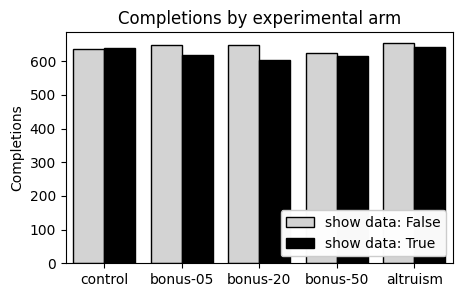

In [13]:
# plot count
fig,ax = plt.subplots(1,1, figsize=(5,3))#, dpi=150)
ax.set_title('Completions by experimental arm')
plot_count(agg_share_df, ax)
# chi-square test
(statistic, pvalue) = chisquare(agg_share_df['count'])
print('chi-square test null hypothesis: Completions count is the same across experimental arms')
print('chi-square test result: stat=%0.3f, p-value=%0.3f' % (statistic, pvalue))
if pvalue > 0.05:
    print('We do not reject the null hypothesis')
else:
    print('We reject the null hypothesis')

In [14]:
def plot_share_rate(pdf, ax, overall_share_rate=overall_share_rate):
    width = 0.4
    (pdf[pdf['showdata']==False]['mean']
     .plot(
        kind='bar', color='lightgray', edgecolor='black', #hatch='//',
        label='show data: False',
        ax=ax, width=width, position=1
    ))
    (pdf[pdf['showdata']==True]['mean']
     .plot(
        kind='bar', color='black', 
        edgecolor='black', 
        label='show data: True',
        ax=ax, width=width, position=0)
    )
    if overall_share_rate is not None:
        ax.hlines(overall_share_rate, -1, 5, color='gray', label='overall')
    ax.set_ylabel('Share rate')
    #ax.set_xlabel('incentive (random experiment arm)')
    ax.set_xlim([-0.5,4.5])
    ax.legend(facecolor='white', framealpha=0.98, loc='lower right')
    ax.set_ylim([0,1])
    _ = ax.set_xticklabels(pdf[pdf['showdata']==True]['incentive'], rotation=0)

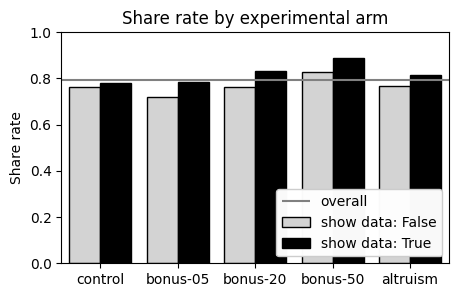

In [15]:
fig,ax = plt.subplots(1,1, figsize=(5,3), dpi=100)
ax.set_title('Share rate by experimental arm')
plot_share_rate(agg_share_df, ax)

observations for more analysis below:

- showdata=true consistently higher share rate
- more money reward --> more sharing
- incentive bonus: \$0.05 x (show data=False) has negative effect compared to control
- incentive: altruism x (show data=True) increases sharing vs control

## Helper functions for analysis

In [16]:
# displaying / printing helpers
def get_predictors_table(model):
    return pd.DataFrame({
        'B (log odds)': model.params.apply(round, args=([3])),
        'Odds Ratio': np.exp(model.params).apply(round, args=([3])), 
        '95% CI for Odds Ratio': (
            np.exp(model.conf_int())
            .apply(lambda r: '[%0.3f, %0.3f]'%(r[0], r[1]), axis=1)
        ),
        'P-value': model.pvalues.apply(round, args=([3]))
    }).rename_axis('Predictor')

## Impact of showing participants data (show data=true)

Across all incentives

In [17]:
formula = "share ~ showdata"
model = smf.logit(formula=formula, data=df).fit()
display(model.summary2())
display(get_predictors_table(model))

Optimization terminated successfully.
         Current function value: 0.506601
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.004     
Dependent Variable: share            AIC:              6412.5048 
Date:               2023-05-09 14:05 BIC:              6426.0093 
No. Observations:   6325             Log-Likelihood:   -3204.3   
Df Model:           1                LL-Null:          -3217.0   
Df Residuals:       6323             LLR p-value:      4.3602e-07
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
-----------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
-----------------------------------------------------------------
Intercept            1.2010   0.0419 28.6831 0.0000 1.1189 1.2831
showdata[T.True]     0.3155   0.0627  5.0342 0.0000 0.1927 0.4383
=================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.201,3.323,"[3.062, 3.608]",0.0
showdata[T.True],0.315,1.371,"[1.212, 1.550]",0.0


Limiting data to incentive=control --> Result not statistically significant

In [18]:
# Limiting data to incentive=control
formula = "share ~ showdata"
model = smf.logit(formula=formula, data=df[df['incentive']=='control']).fit()
display(model.summary2())
display(get_predictors_table(model))

Optimization terminated successfully.
         Current function value: 0.537890
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.000    
Dependent Variable: share            AIC:              1375.6196
Date:               2023-05-09 14:05 BIC:              1385.9210
No. Observations:   1275             Log-Likelihood:   -685.81  
Df Model:           1                LL-Null:          -686.06  
Df Residuals:       1273             LLR p-value:      0.47627  
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     5.0000                                      
----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
----------------------------------------------------------------
Intercept          1.1669   0.0932 12.5214 0.0000  0.9842 1.3495
showdata[T.True]   0.0950   0.1334  0.7121 0.4764 -0.1664 0.3563
================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.167,3.212,"[2.676, 3.856]",0.000
showdata[T.True],0.095,1.100,"[0.847, 1.428]",0.476


The showdata:true effect is not statistically signiciant when limiting to incentive=control.

Is the showdata:true effect significant when limiting to any of the incentive treatments?

For which is this the case?

In [19]:
formula = 'share ~ showdata'
incentives = ['control', 'altruism', 'bonus-05', 'bonus-20', 'bonus-50']
for incentive in incentives:
    print('\n--- incentive=%s ----\n' % incentive)
    model = smf.logit(formula=formula, data=df[df['incentive']==incentive]).fit()
    display(model.summary2())
    display(get_predictors_table(model))


--- incentive=control ----

Optimization terminated successfully.
         Current function value: 0.537890
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.000    
Dependent Variable: share            AIC:              1375.6196
Date:               2023-05-09 14:05 BIC:              1385.9210
No. Observations:   1275             Log-Likelihood:   -685.81  
Df Model:           1                LL-Null:          -686.06  
Df Residuals:       1273             LLR p-value:      0.47627  
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     5.0000                                      
----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
----------------------------------------------------------------
Intercept          1.1669   0.0932 12.5214 0.0000  0.9842 1.3495
showdata[T.True]   0.0950   0.1334  0.7121 0.4764 -0.1664 0.3563
================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.167,3.212,"[2.676, 3.856]",0.000
showdata[T.True],0.095,1.100,"[0.847, 1.428]",0.476



--- incentive=altruism ----

Optimization terminated successfully.
         Current function value: 0.510134
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.004    
Dependent Variable: share            AIC:              1325.2473
Date:               2023-05-09 14:05 BIC:              1335.5798
No. Observations:   1295             Log-Likelihood:   -660.62  
Df Model:           1                LL-Null:          -662.98  
Df Residuals:       1293             LLR p-value:      0.029891 
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     5.0000                                      
----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
----------------------------------------------------------------
Intercept           1.1927   0.0926 12.8803 0.0000 1.0112 1.3742
showdata[T.True]    0.2981   0.1377  2.1649 0.0304 0.0282 0.5679
================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.193,3.296,"[2.749, 3.952]",0.00
showdata[T.True],0.298,1.347,"[1.029, 1.765]",0.03



--- incentive=bonus-05 ----

Optimization terminated successfully.
         Current function value: 0.557574
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.005    
Dependent Variable: share            AIC:              1414.6616
Date:               2023-05-09 14:05 BIC:              1424.9473
No. Observations:   1265             Log-Likelihood:   -705.33  
Df Model:           1                LL-Null:          -708.87  
Df Residuals:       1263             LLR p-value:      0.0077898
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     5.0000                                      
----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
----------------------------------------------------------------
Intercept           0.9457   0.0876 10.7976 0.0000 0.7740 1.1173
showdata[T.True]    0.3481   0.1313  2.6504 0.0080 0.0907 0.6055
================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,0.946,2.575,"[2.168, 3.057]",0.000
showdata[T.True],0.348,1.416,"[1.095, 1.832]",0.008



--- incentive=bonus-20 ----

Optimization terminated successfully.
         Current function value: 0.498952
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.007    
Dependent Variable: share            AIC:              1251.3808
Date:               2023-05-09 14:05 BIC:              1261.6425
No. Observations:   1250             Log-Likelihood:   -623.69  
Df Model:           1                LL-Null:          -628.27  
Df Residuals:       1248             LLR p-value:      0.0024865
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     5.0000                                      
----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
----------------------------------------------------------------
Intercept           1.1827   0.0927 12.7570 0.0000 1.0010 1.3644
showdata[T.True]    0.4307   0.1435  3.0020 0.0027 0.1495 0.7120
================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.183,3.263,"[2.721, 3.913]",0.000
showdata[T.True],0.431,1.538,"[1.161, 2.038]",0.003



--- incentive=bonus-50 ----

Optimization terminated successfully.
         Current function value: 0.403532
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.009    
Dependent Variable: share            AIC:              1004.7588
Date:               2023-05-09 14:05 BIC:              1015.0045
No. Observations:   1240             Log-Likelihood:   -500.38  
Df Model:           1                LL-Null:          -504.69  
Df Residuals:       1238             LLR p-value:      0.0033243
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     6.0000                                      
----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
----------------------------------------------------------------
Intercept           1.5865   0.1066 14.8825 0.0000 1.3776 1.7955
showdata[T.True]    0.4838   0.1664  2.9077 0.0036 0.1577 0.8099
================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.587,4.887,"[3.965, 6.022]",0.000
showdata[T.True],0.484,1.622,"[1.171, 2.248]",0.004


```
This effect varies by incentive arm. 
This effect is not statistically significant for the control, but is statistically significant for all other incentive arms.
The effect  size increases with monetary bonus.

incentive=control: Treatment is not statistically significant
For all other incentives, p < 0.05
incentive=altruism
showdata:true experiment arm had 1.35 times the odds of sharing over showdata:false
incentive=bonus:0.05
showdata:true experiment arm had 1.4 times the odds of sharing over showdata:false
incentive=bonus:0.20
showdata:true experiment arm had 1.54 times the odds of sharing over showdata:false
incentive=bonus:0.50
showdata:true experiment arm had 1.62 times the odds of sharing over showdata:false

```

## Interaction effect between incentive and showdata

There's nothing to see here.

In [20]:
formula = "share ~ C(incentive, Treatment(reference='control'))*showdata"
model = smf.logit(formula=formula, data=df).fit()
display(model.summary2())

Optimization terminated successfully.
         Current function value: 0.502108
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                     Results: Logit
========================================================================================================================
Model:                                 Logit                              Pseudo R-squared:                   0.013     
Dependent Variable:                    share                              AIC:                                6371.6680 
Date:                                  2023-05-09 14:05                   BIC:                                6439.1906 
No. Observations:                      6325                               Log-Likelihood:                     -3175.8   
Df Model:                              9                                  LL-Null:                            -3217.0   
Df Residuals:                          6315                               LLR p-value:                        5.4719e-14
Converged:                             1.0000                             Scale:                              1.0000    
No. Iterations:                        6.0000                                                                           
------------------------------------------------------------------------------------------------------------------------
                                                                           Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                                                  1.1669   0.0932 12.5214 0.0000  0.9842 1.3495
C(incentive, Treatment(reference='control'))[T.altruism]                   0.0259   0.1314  0.1968 0.8440 -0.2316 0.2833
C(incentive, Treatment(reference='control'))[T.bonus-05]                  -0.2212   0.1279 -1.7295 0.0837 -0.4718 0.0295
C(incentive, Treatment(reference='control'))[T.bonus-20]                   0.0158   0.1315  0.1204 0.9042 -0.2418 0.2735
C(incentive, Treatment(reference='control'))[T.bonus-50]                   0.4197   0.1416  2.9639 0.0030  0.1421 0.6972
showdata[T.True]                                                           0.0950   0.1334  0.7121 0.4764 -0.1664 0.3563
C(incentive, Treatment(reference='control'))[T.altruism]:showdata[T.True]  0.2031   0.1917  1.0596 0.2893 -0.1726 0.5788
C(incentive, Treatment(reference='control'))[T.bonus-05]:showdata[T.True]  0.2531   0.1872  1.3524 0.1762 -0.1137 0.6200
C(incentive, Treatment(reference='control'))[T.bonus-20]:showdata[T.True]  0.3358   0.1959  1.7141 0.0865 -0.0482 0.7197
C(incentive, Treatment(reference='control'))[T.bonus-50]:showdata[T.True]  0.3888   0.2132  1.8235 0.0682 -0.0291 0.8068
========================================================================================================================

"""

## Effect of incentives

Look across both showdata:true/false

Look at each of showdata:true/false independently

Across all data

In [21]:
# Across all data
formula = "share ~ C(incentive, Treatment(reference='control'))"
model = smf.logit(formula=formula, data=df).fit()
display(model.summary2())
display(get_predictors_table(model))

Optimization terminated successfully.
         Current function value: 0.504486
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                            Logit                        Pseudo R-squared:             0.008     
Dependent Variable:               share                        AIC:                          6391.7430 
Date:                             2023-05-09 14:05             BIC:                          6425.5043 
No. Observations:                 6325                         Log-Likelihood:               -3190.9   
Df Model:                         4                            LL-Null:                      -3217.0   
Df Residuals:                     6320                         LLR p-value:                  1.1999e-10
Converged:                        1.0000                       Scale:                        1.0000    
No. Iterations:                   6.0000                                                               
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 1.2139   0.0666 18.2129 0.0000  1.0832 1.3445
C(incentive, Treatment(reference='control'))[T.altruism]  0.1202   0.0955  1.2583 0.2083 -0.0670 0.3074
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.1057   0.0932 -1.1350 0.2564 -0.2883 0.0768
C(incentive, Treatment(reference='control'))[T.bonus-20]  0.1625   0.0970  1.6747 0.0940 -0.0277 0.3526
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.5921   0.1053  5.6211 0.0000  0.3856 0.7985
=======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.214,3.366,"[2.954, 3.836]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.120,1.128,"[0.935, 1.360]",0.208
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.106,0.900,"[0.750, 1.080]",0.256
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.162,1.176,"[0.973, 1.423]",0.094
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.592,1.808,"[1.471, 2.222]",0.000


By showdata arm

In [22]:
print('---- For showdata:True ----')
formula = "share ~ C(incentive, Treatment(reference='control'))"
model = smf.logit(formula=formula, data=df[df['showdata']==True]).fit()
display(model.summary2())
display(get_predictors_table(model))

---- For showdata:True ----
Optimization terminated successfully.
         Current function value: 0.465866
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
======================================================================================================
Model:                           Logit                        Pseudo R-squared:             0.012     
Dependent Variable:              share                        AIC:                          2914.2069 
Date:                            2023-05-09 14:05             BIC:                          2944.4300 
No. Observations:                3117                         Log-Likelihood:               -1452.1   
Df Model:                        4                            LL-Null:                      -1469.2   
Df Residuals:                    3112                         LLR p-value:                  6.5344e-07
Converged:                       1.0000                       Scale:                        1.0000    
No. Iterations:                  6.0000                                                               
------------------------------------------------------------------------------------------------------
                                                         Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
------------------------------------------------------------------------------------------------------
Intercept                                                1.2618   0.0954 13.2275 0.0000  1.0749 1.4488
C(incentive, Treatment(reference='control'))[T.altruism] 0.2290   0.1396  1.6404 0.1009 -0.0446 0.5025
C(incentive, Treatment(reference='control'))[T.bonus-05] 0.0320   0.1367  0.2338 0.8151 -0.2359 0.2998
C(incentive, Treatment(reference='control'))[T.bonus-20] 0.3516   0.1452  2.4209 0.0155  0.0669 0.6362
C(incentive, Treatment(reference='control'))[T.bonus-50] 0.8085   0.1594  5.0709 0.0000  0.4960 1.1210
======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.262,3.532,"[2.930, 4.258]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.229,1.257,"[0.956, 1.653]",0.101
"C(incentive, Treatment(reference='control'))[T.bonus-05]",0.032,1.032,"[0.790, 1.350]",0.815
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.352,1.421,"[1.069, 1.889]",0.015
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.809,2.245,"[1.642, 3.068]",0.000


In [23]:
print('---- For showdata:False -----')
formula = "share ~ C(incentive, Treatment(reference='control'))"
model = smf.logit(formula=formula, data=df[df['showdata']==False]).fit()
display(model.summary2())
display(get_predictors_table(model))

---- For showdata:False -----
Optimization terminated successfully.
         Current function value: 0.537322
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                            Logit                        Pseudo R-squared:             0.007     
Dependent Variable:               share                        AIC:                          3457.4611 
Date:                             2023-05-09 14:05             BIC:                          3487.8281 
No. Observations:                 3208                         Log-Likelihood:               -1723.7   
Df Model:                         4                            LL-Null:                      -1735.0   
Df Residuals:                     3203                         LLR p-value:                  0.00015511
Converged:                        1.0000                       Scale:                        1.0000    
No. Iterations:                   5.0000                                                               
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 1.1669   0.0932 12.5214 0.0000  0.9842 1.3495
C(incentive, Treatment(reference='control'))[T.altruism]  0.0259   0.1314  0.1968 0.8440 -0.2316 0.2833
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.2212   0.1279 -1.7295 0.0837 -0.4718 0.0295
C(incentive, Treatment(reference='control'))[T.bonus-20]  0.0158   0.1315  0.1204 0.9042 -0.2418 0.2735
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.4197   0.1416  2.9639 0.0030  0.1421 0.6972
=======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.167,3.212,"[2.676, 3.856]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.026,1.026,"[0.793, 1.328]",0.844
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.221,0.802,"[0.624, 1.030]",0.084
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.016,1.016,"[0.785, 1.315]",0.904
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.420,1.521,"[1.153, 2.008]",0.003


## Sharing differences across demographic groups

We analyze across all experiment arms, and for just control arms.

In [24]:
def add_n_labels(ax, values):
    for rect, val in zip(ax.patches, values):
        # Get X and Y placement of label from rect.
        y_value = rect.get_y() + rect.get_height() / 2
        x_value = 0.02
        ax.annotate(
            'n=%s'%val, 
            (x_value, y_value),
            va='center',
        )

        
def plot_survey_proportion_with_N(df, ax):
    ax.barh(df.index, df['survey proportion'], color='lightgray',  edgecolor='black')
    ax.set_xlabel('Proportion')
    ax.set_ylabel('')
    add_n_labels(ax, df['survey N'])
    
    
def get_share_rate_by_Q_df(Q, new_col_name=None, df=df):
    share_df = (
        df.groupby([Q])['share']
        .agg(['count','mean']).round(3).reset_index()
        .rename(columns={'count':'n', 'mean':'share rate'})
    )
    if new_col_name:
        share_df = share_df.rename({Q:new_col_name}, axis=1)
    return share_df


def plot_share_by_demo(plt_df, demo_col, ax, control_only=False):
    ax.barh(
        plt_df[demo_col], plt_df['share rate'],
        color='lightgray',  edgecolor='black'
    )
    ax.set_xlim([0,1])
    ax.set_xlabel('Share rate')
    ax.set_ylabel('')
    ax.set_title('Share rate by %s%s' % (demo_col, ' (control only)' if control_only else ''))
    share_rate = control_share_rate if control_only else overall_share_rate
    ax.axvline(share_rate, color='black')
    # annotate with labels
    add_n_labels(ax, plt_df['n'])

### By gender

How do you describe yourself?


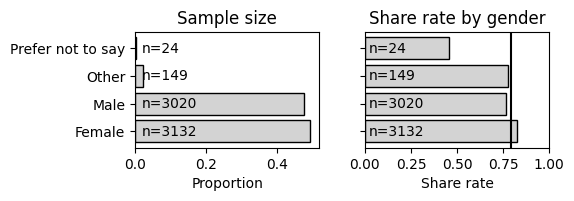

,gender,n,share rate
0,Female,3132,0.825
1,Male,3020,0.765
2,Other,149,0.779
3,Prefer not to say,24,0.458


In [25]:
Q = 'Q-demos-gender'
print(fields_df.loc[Q][0])
gender_df = df[Q].value_counts().rename('survey N').to_frame()
gender_df['survey proportion'] = gender_df['survey N']/gender_df['survey N'].sum()
figsize=(2.5, 1.75)
fig, axes = plt.subplots(1,2,figsize=(figsize[0]*2,figsize[1]), dpi=100, sharey=True)
plt.tight_layout()
plot_survey_proportion_with_N(gender_df, axes[0])
axes[0].set_title('Sample size')
colname = 'gender'
gender_share_df = get_share_rate_by_Q_df(Q, colname)
plot_share_by_demo(gender_share_df, colname, axes[1])
plt.show()
gender_share_df

control only


,gender,n,share rate
0,Female,654,0.786
1,Male,584,0.764
2,Other,32,0.688
3,Prefer not to say,5,0.200


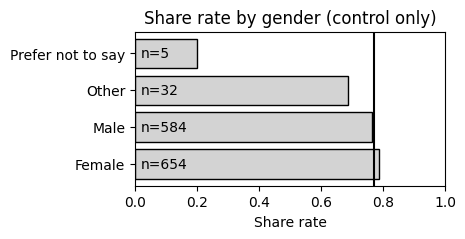

In [26]:
print('control only')
gender_share_df = get_share_rate_by_Q_df(Q, colname, df=control_df)
fig,ax = plt.subplots(1,1, figsize=(4, 0.5*len(gender_share_df)))
plot_share_by_demo(gender_share_df, colname, ax, control_only=True)
gender_share_df

Model: Are females significantly more likely to share versus males?

We limit model data to just Male/Female binary

Answer:

- Yes when we include all experimental arms
- No when just the control arm

In [27]:
# limit to just male/female
# mape male/female to binary 0/1

gender_binary_df = df[df[Q].isin(['Male','Female'])].copy()
gender_binary_df['gender'] = gender_binary_df[Q]
formula = "share ~ C(gender, Treatment(reference='Male'))"
model = smf.logit(formula=formula, data=gender_binary_df).fit()
print('\n',formula)
display(model.summary2())
display(get_predictors_table(model))
# check for just the control group too
model = smf.logit(formula=formula, data=get_control_df(gender_binary_df)).fit()
print('\nControl arm only:\n',formula)
display(model.summary2())

Optimization terminated successfully.
         Current function value: 0.503525
         Iterations 5

 share ~ C(gender, Treatment(reference='Male'))


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                       Results: Logit
=============================================================================================
Model:                        Logit                     Pseudo R-squared:          0.006     
Dependent Variable:           share                     AIC:                       6199.3724 
Date:                         2023-05-09 14:05          BIC:                       6212.8214 
No. Observations:             6152                      Log-Likelihood:            -3097.7   
Df Model:                     1                         LL-Null:                   -3115.0   
Df Residuals:                 6150                      LLR p-value:               4.0181e-09
Converged:                    1.0000                    Scale:                     1.0000    
No. Iterations:               5.0000                                                         
---------------------------------------------------------------------------------------------
                                                 Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------------------------------
Intercept                                        1.1797   0.0429 27.4927 0.0000 1.0956 1.2638
C(gender, Treatment(reference='Male'))[T.Female] 0.3733   0.0637  5.8612 0.0000 0.2485 0.4981
=============================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.180,3.254,"[2.991, 3.539]",0.0
"C(gender, Treatment(reference='Male'))[T.Female]",0.373,1.453,"[1.282, 1.646]",0.0


Optimization terminated successfully.
         Current function value: 0.532260
         Iterations 5

Control arm only:
 share ~ C(gender, Treatment(reference='Male'))


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                        Results: Logit
==============================================================================================
Model:                        Logit                      Pseudo R-squared:           0.001    
Dependent Variable:           share                      AIC:                        1321.8768
Date:                         2023-05-09 14:05           BIC:                        1332.1194
No. Observations:             1238                       Log-Likelihood:             -658.94  
Df Model:                     1                          LL-Null:                    -659.38  
Df Residuals:                 1236                       LLR p-value:                0.34958  
Converged:                    1.0000                     Scale:                      1.0000   
No. Iterations:               5.0000                                                          
----------------------------------------------------------------------------------------------
                                                 Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                        1.1731   0.0974 12.0427 0.0000  0.9821 1.3640
C(gender, Treatment(reference='Male'))[T.Female] 0.1275   0.1363  0.9356 0.3495 -0.1396 0.3947
==============================================================================================

"""

In [28]:
gender_agg_df = get_aggregate_share_df(gender_binary_df, extra_groupby=Q)
gender_agg_df

,incentive,showdata,Q-demos-gender,count,mean
0,control,False,Female,333,0.763
1,control,False,Male,286,0.759
2,control,True,Female,321,0.810
3,control,True,Male,298,0.768
4,bonus-05,False,Female,306,0.732
5,bonus-05,False,Male,325,0.705
6,bonus-05,True,Female,301,0.841
7,bonus-05,True,Male,301,0.734
8,bonus-20,False,Female,326,0.776
9,bonus-20,False,Male,308,0.756


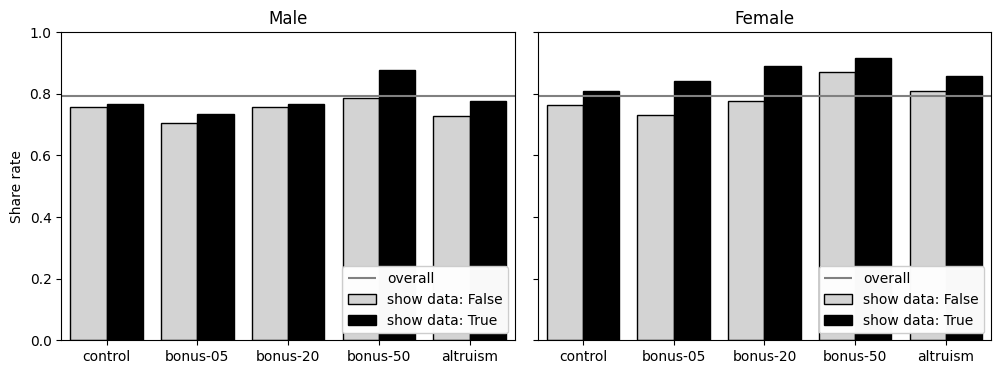

In [29]:
figsize=(6,4)
fig,axes = plt.subplots(1,2,figsize=(figsize[0]*2,figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0.05)
for i, g in enumerate(['Male','Female']):
    demo_df = df[df[Q]==g]
    demo_agg_share_df = get_aggregate_share_df(demo_df)
    ax = axes[i]
    plot_share_rate(demo_agg_share_df, ax)
    ax.set_title(g)

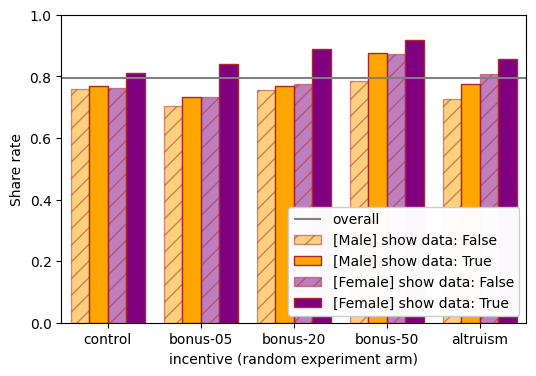

In [30]:
# Plot males and females side by side
gender_colors = {'Male':'orange', 'Female':'purple'}
width = 0.2
figsize=(6,4)
fig,ax = plt.subplots(1,1,figsize=(figsize[0],figsize[1]))
male_df = gender_agg_df[gender_agg_df[Q]=='Male']
female_df = gender_agg_df[gender_agg_df[Q]=='Female']

g = 'Male'
pdf = male_df[male_df['showdata']==False]
pdf['mean'].plot(kind='bar', ax=ax, width=width, position=2,
         color=gender_colors[g], edgecolor='brown', alpha=0.5, hatch='//', 
         label='[%s] show data: False'%g)
pdf = male_df[male_df['showdata']==True]
pdf['mean'].plot(kind='bar', ax=ax, width=width, position=1,
         color=gender_colors[g], edgecolor='brown',
         label='[%s] show data: True'%g)
g = 'Female'
pdf = female_df[female_df['showdata']==False]
pdf['mean'].plot(kind='bar', ax=ax, width=width, position=0,
         color=gender_colors[g], edgecolor='brown', alpha=0.5, hatch='//', 
         label='[%s] show data: False'%g)
pdf = female_df[female_df['showdata']==True]
pdf['mean'].plot(kind='bar', ax=ax, width=width, position=-1,
         color=gender_colors[g], edgecolor='brown',
         label='[%s] show data: True'%g)
if overall_share_rate is not None:
    ax.hlines(overall_share_rate, -1, 5, color='gray', label='overall')
ax.set_ylabel('Share rate')
ax.set_xlabel('incentive (random experiment arm)')
ax.set_xlim([-0.5,4.5])
ax.legend(facecolor='white', framealpha=0.98, loc='lower right')
ax.set_ylim([0,1])
_ = ax.set_xticklabels(pdf['incentive'], rotation=0)

### Interaction effect between gender and showdata



In [31]:
formula = "share ~ showdata*C(gender, Treatment(reference='Male'))"
print(formula)
model = smf.logit(formula=formula, data=gender_binary_df).fit()
display(model.summary2())
display(get_predictors_table(model))

share ~ showdata*C(gender, Treatment(reference='Male'))
Optimization terminated successfully.
         Current function value: 0.500669
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                Results: Logit
==============================================================================================================
Model:                             Logit                           Pseudo R-squared:                0.011     
Dependent Variable:                share                           AIC:                             6168.2308 
Date:                              2023-05-09 14:05                BIC:                             6195.1289 
No. Observations:                  6152                            Log-Likelihood:                  -3080.1   
Df Model:                          3                               LL-Null:                         -3115.0   
Df Residuals:                      6148                            LLR p-value:                     4.8128e-15
Converged:                         1.0000                          Scale:                           1.0000    
No. Iterations:                    6.0000                                                                     
--------------------------------------------------------------------------------------------------------------
                                                                  Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                                         1.0725   0.0588 18.2353 0.0000 0.9572 1.1878
showdata[T.True]                                                  0.2228   0.0861  2.5876 0.0097 0.0540 0.3916
C(gender, Treatment(reference='Male'))[T.Female]                  0.2532   0.0850  2.9788 0.0029 0.0866 0.4198
showdata[T.True]:C(gender, Treatment(reference='Male'))[T.Female] 0.2850   0.1291  2.2067 0.0273 0.0319 0.5381
==============================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.073,2.923,"[2.604, 3.280]",0.000
showdata[T.True],0.223,1.250,"[1.056, 1.479]",0.010
"C(gender, Treatment(reference='Male'))[T.Female]",0.253,1.288,"[1.090, 1.522]",0.003
"showdata[T.True]:C(gender, Treatment(reference='Male'))[T.Female]",0.285,1.330,"[1.032, 1.713]",0.027


### Interaction effect between gender and experiment arms

In [32]:
formula = "share ~ C(incentive, Treatment(reference='control'))*C(gender, Treatment(reference='Male'))"
model = smf.logit(formula=formula, data=gender_binary_df).fit()
display(model.summary2())
display(get_predictors_table(model))

Optimization terminated successfully.
         Current function value: 0.498697
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                     Results: Logit
========================================================================================================================================================
Model:                                           Logit                                         Pseudo R-squared:                              0.015     
Dependent Variable:                              share                                         AIC:                                           6155.9685 
Date:                                            2023-05-09 14:05                              BIC:                                           6223.2138 
No. Observations:                                6152                                          Log-Likelihood:                                -3068.0   
Df Model:                                        9                                             LL-Null:                                       -3115.0   
Df Residuals:                                    6142                                          LLR p-value:                                   2.5347e-16
Converged:                                       1.0000                                        Scale:                                         1.0000    
No. Iterations:                                  6.0000                                                                                                 
--------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                           Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                  1.1731   0.0974 12.0427 0.0000  0.9821 1.3640
C(incentive, Treatment(reference='control'))[T.altruism]                                                  -0.0660   0.1338 -0.4935 0.6216 -0.3283 0.1962
C(incentive, Treatment(reference='control'))[T.bonus-05]                                                  -0.2343   0.1319 -1.7766 0.0756 -0.4928 0.0242
C(incentive, Treatment(reference='control'))[T.bonus-20]                                                  -0.0117   0.1376 -0.0851 0.9322 -0.2814 0.2580
C(incentive, Treatment(reference='control'))[T.bonus-50]                                                   0.4303   0.1470  2.9263 0.0034  0.1421 0.7185
C(gender, Treatment(reference='Male'))[T.Female]                                                           0.1275   0.1363  0.9356 0.3495 -0.1396 0.3947
C(incentive, Treatment(reference='control'))[T.altruism]:C(gender, Treatment(reference='Male'))[T.Female]  0.3673   0.1961  1.8732 0.0610 -0.0170 0.7515
C(incentive, Treatment(reference='control'))[T.bonus-05]:C(gender, Treatment(reference='Male'))[T.Female]  0.2337   0.1904  1.2271 0.2198 -0.1396 0.6070
C(incentive, Treatment(reference='control'))[T.bonus-20]:C(gender, Treatment(reference='Male'))[T.Female]  0.3074   0.1981  1.5514 0.1208 -0.0810 0.6958
C(incentive, Treatment(reference='control'))[T.bonus-50]:C(gender, Treatment(reference='Male'))[T.Female]  0.3955   0.2189  1.8066 0.0708 -0.0336 0.8246
========================================================================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.173,3.232,"[2.670, 3.912]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",-0.066,0.936,"[0.720, 1.217]",0.622
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.234,0.791,"[0.611, 1.024]",0.076
"C(incentive, Treatment(reference='control'))[T.bonus-20]",-0.012,0.988,"[0.755, 1.294]",0.932
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.430,1.538,"[1.153, 2.051]",0.003
"C(gender, Treatment(reference='Male'))[T.Female]",0.128,1.136,"[0.870, 1.484]",0.349
"C(incentive, Treatment(reference='control'))[T.altruism]:C(gender, Treatment(reference='Male'))[T.Female]",0.367,1.444,"[0.983, 2.120]",0.061
"C(incentive, Treatment(reference='control'))[T.bonus-05]:C(gender, Treatment(reference='Male'))[T.Female]",0.234,1.263,"[0.870, 1.835]",0.220
"C(incentive, Treatment(reference='control'))[T.bonus-20]:C(gender, Treatment(reference='Male'))[T.Female]",0.307,1.360,"[0.922, 2.005]",0.121


### Picking out gender variable 

In [33]:
formula = "share ~ C(incentive, Treatment(reference='control')) + C(gender, Treatment(reference='Male'))"
model = smf.logit(formula=formula, data=gender_binary_df).fit()
display(model.summary2())
display(get_predictors_table(model))

Optimization terminated successfully.
         Current function value: 0.499100
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                            Logit                        Pseudo R-squared:             0.014     
Dependent Variable:               share                        AIC:                          6152.9240 
Date:                             2023-05-09 14:05             BIC:                          6193.2712 
No. Observations:                 6152                         Log-Likelihood:               -3070.5   
Df Model:                         5                            LL-Null:                      -3115.0   
Df Residuals:                     6146                         LLR p-value:                  1.0570e-17
Converged:                        1.0000                       Scale:                        1.0000    
No. Iterations:                   6.0000                                                               
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 1.0509   0.0748 14.0451 0.0000  0.9042 1.1975
C(incentive, Treatment(reference='control'))[T.altruism]  0.1080   0.0975  1.1076 0.2680 -0.0831 0.2990
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.1182   0.0951 -1.2432 0.2138 -0.3047 0.0682
C(incentive, Treatment(reference='control'))[T.bonus-20]  0.1381   0.0989  1.3959 0.1627 -0.0558 0.3321
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.6157   0.1085  5.6763 0.0000  0.4031 0.8282
C(gender, Treatment(reference='Male'))[T.Female]          0.3750   0.0640  5.8610 0.0000  0.2496 0.5004
=======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.051,2.860,"[2.470, 3.312]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.108,1.114,"[0.920, 1.349]",0.268
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.118,0.888,"[0.737, 1.071]",0.214
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.138,1.148,"[0.946, 1.394]",0.163
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.616,1.851,"[1.496, 2.289]",0.000
"C(gender, Treatment(reference='Male'))[T.Female]",0.375,1.455,"[1.284, 1.649]",0.000


### By income group

In [34]:
income_order = [
    'Prefer not to say', 'Less than \$25,000','\$25,000 - \$49,999',  '\$50,000 - \$74,999', 
    '\$75,000 - \$99,999',  '\$100,000 - \$149,999', '\$150,000 or more'
]

Overall

What was your total household income before taxes during the past 12 months?


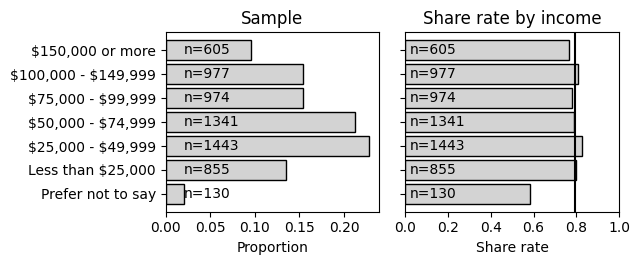

,income,n,share rate
0,Prefer not to say,130,0.585
1,"Less than \$25,000",855,0.801
2,"\$25,000 - \$49,999",1443,0.825
3,"\$50,000 - \$74,999",1341,0.791
4,"\$75,000 - \$99,999",974,0.779
5,"\$100,000 - \$149,999",977,0.807
6,"\$150,000 or more",605,0.764


In [36]:
Q = 'Q-demos-income'
print(fields_df.loc[Q][0])
income_df = df[Q].value_counts().rename('survey N').to_frame()
income_df['survey proportion'] = income_df['survey N']/income_df['survey N'].sum()
# order by income
income_df = income_df.loc[income_order]
figsize = (3.25, 2.75)
fig, axes = plt.subplots(1,2,figsize=(figsize[0]*2,figsize[1]), dpi=100, sharey=True)
ax = axes[0]
plot_survey_proportion_with_N(income_df, ax)
ax.set_title('Sample')
colname = 'income'
income_share_df = get_share_rate_by_Q_df(Q, colname)
# order by income
income_share_df = income_share_df.set_index('income').loc[income_order].reset_index()
ax = axes[1]
plot_share_by_demo(income_share_df, colname, ax)
plt.tight_layout()
plt.show()
income_share_df

#### Evaluate each incentive arm separately

Q-demos-income
share ~ C(income)
------- control -------
Optimization terminated successfully.
         Current function value: 0.529435
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                  Results: Logit
==================================================================================
Model:                    Logit                  Pseudo R-squared:       0.016    
Dependent Variable:       share                  AIC:                    1364.0593
Date:                     2023-05-09 14:06       BIC:                    1400.1142
No. Observations:         1275                   Log-Likelihood:         -675.03  
Df Model:                 6                      LL-Null:                -686.06  
Df Residuals:             1268                   LLR p-value:            0.0011771
Converged:                1.0000                 Scale:                  1.0000   
No. Iterations:           5.0000                                                  
----------------------------------------------------------------------------------
                                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------
Intercept                           1.1582   0.1860  6.2283 0.0000  0.7937  1.5227
C(income)[T.Prefer not to say]     -1.3946   0.3923 -3.5552 0.0004 -2.1634 -0.6258
C(income)[T.\$100,000 - \$149,999]  0.2101   0.2539  0.8275 0.4080 -0.2875  0.7076
C(income)[T.\$150,000 or more]     -0.1221   0.2750 -0.4440 0.6570 -0.6611  0.4169
C(income)[T.\$25,000 - \$49,999]    0.3166   0.2394  1.3224 0.1860 -0.1527  0.7860
C(income)[T.\$50,000 - \$74,999]    0.0747   0.2384  0.3131 0.7542 -0.3926  0.5420
C(income)[T.\$75,000 - \$99,999]    0.0075   0.2488  0.0303 0.9758 -0.4801  0.4952
==================================================================================

"""

------- bonus-05 -------
Optimization terminated successfully.
         Current function value: 0.553671
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                  Results: Logit
==================================================================================
Model:                    Logit                  Pseudo R-squared:       0.012    
Dependent Variable:       share                  AIC:                    1414.7888
Date:                     2023-05-09 14:06       BIC:                    1450.7886
No. Observations:         1265                   Log-Likelihood:         -700.39  
Df Model:                 6                      LL-Null:                -708.87  
Df Residuals:             1258                   LLR p-value:            0.0094539
Converged:                1.0000                 Scale:                  1.0000   
No. Iterations:           5.0000                                                  
----------------------------------------------------------------------------------
                                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------
Intercept                           1.1939   0.1805  6.6150 0.0000  0.8402  1.5477
C(income)[T.Prefer not to say]     -1.1294   0.4022 -2.8082 0.0050 -1.9176 -0.3411
C(income)[T.\$100,000 - \$149,999]  0.0273   0.2464  0.1108 0.9118 -0.4557  0.5103
C(income)[T.\$150,000 or more]     -0.1925   0.2656 -0.7246 0.4687 -0.7131  0.3281
C(income)[T.\$25,000 - \$49,999]    0.1024   0.2312  0.4428 0.6579 -0.3508  0.5555
C(income)[T.\$50,000 - \$74,999]    0.0713   0.2347  0.3038 0.7613 -0.3887  0.5312
C(income)[T.\$75,000 - \$99,999]   -0.4512   0.2400 -1.8801 0.0601 -0.9215  0.0192
==================================================================================

"""

------- bonus-20 -------
Optimization terminated successfully.
         Current function value: 0.500181
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                 Results: Logit
=================================================================================
Model:                     Logit                 Pseudo R-squared:      0.005    
Dependent Variable:        share                 AIC:                   1264.4533
Date:                      2023-05-09 14:06      BIC:                   1300.3696
No. Observations:          1250                  Log-Likelihood:        -625.23  
Df Model:                  6                     LL-Null:               -628.27  
Df Residuals:              1243                  LLR p-value:           0.41451  
Converged:                 1.0000                Scale:                 1.0000   
No. Iterations:            5.0000                                                
---------------------------------------------------------------------------------
                                    Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                           1.4971   0.1956  7.6556 0.0000  1.1138 1.8804
C(income)[T.Prefer not to say]     -0.8910   0.5439 -1.6381 0.1014 -1.9570 0.1750
C(income)[T.\$100,000 - \$149,999] -0.0740   0.2632 -0.2812 0.7786 -0.5898 0.4418
C(income)[T.\$150,000 or more]     -0.0773   0.3077 -0.2512 0.8017 -0.6804 0.5258
C(income)[T.\$25,000 - \$49,999]    0.0715   0.2498  0.2862 0.7747 -0.4181 0.5611
C(income)[T.\$50,000 - \$74,999]   -0.3068   0.2457 -1.2489 0.2117 -0.7883 0.1747
C(income)[T.\$75,000 - \$99,999]   -0.2279   0.2608 -0.8736 0.3823 -0.7391 0.2834
=================================================================================

"""

------- bonus-50 -------
Optimization terminated successfully.
         Current function value: 0.402887
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                  Results: Logit
==================================================================================
Model:                    Logit                  Pseudo R-squared:       0.010    
Dependent Variable:       share                  AIC:                    1013.1587
Date:                     2023-05-09 14:06       BIC:                    1049.0188
No. Observations:         1240                   Log-Likelihood:         -499.58  
Df Model:                 6                      LL-Null:                -504.69  
Df Residuals:             1233                   LLR p-value:            0.11567  
Converged:                1.0000                 Scale:                  1.0000   
No. Iterations:           6.0000                                                  
----------------------------------------------------------------------------------
                                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------
Intercept                           1.6917   0.2057  8.2259 0.0000  1.2886  2.0947
C(income)[T.Prefer not to say]     -0.9379   0.4755 -1.9724 0.0486 -1.8699 -0.0059
C(income)[T.\$100,000 - \$149,999]  0.0807   0.2955  0.2730 0.7848 -0.4984  0.6597
C(income)[T.\$150,000 or more]      0.0131   0.3408  0.0384 0.9694 -0.6549  0.6811
C(income)[T.\$25,000 - \$49,999]    0.3633   0.2805  1.2951 0.1953 -0.1865  0.9131
C(income)[T.\$50,000 - \$74,999]   -0.0334   0.2633 -0.1270 0.8989 -0.5496  0.4827
C(income)[T.\$75,000 - \$99,999]    0.4213   0.3054  1.3797 0.1677 -0.1772  1.0198
==================================================================================

"""

------- altruism -------
Optimization terminated successfully.
         Current function value: 0.509429
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                 Results: Logit
=================================================================================
Model:                     Logit                 Pseudo R-squared:      0.005    
Dependent Variable:        share                 AIC:                   1333.4216
Date:                      2023-05-09 14:06      BIC:                   1369.5854
No. Observations:          1295                  Log-Likelihood:        -659.71  
Df Model:                  6                     LL-Null:               -662.98  
Df Residuals:              1288                  LLR p-value:           0.36536  
Converged:                 1.0000                Scale:                 1.0000   
No. Iterations:            5.0000                                                
---------------------------------------------------------------------------------
                                    Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                           1.4542   0.1963  7.4068 0.0000  1.0694 1.8391
C(income)[T.Prefer not to say]     -0.4128   0.5138 -0.8033 0.4218 -1.4199 0.5943
C(income)[T.\$100,000 - \$149,999] -0.0124   0.2718 -0.0456 0.9637 -0.5451 0.5203
C(income)[T.\$150,000 or more]     -0.5160   0.2778 -1.8571 0.0633 -1.0605 0.0286
C(income)[T.\$25,000 - \$49,999]    0.0419   0.2458  0.1703 0.8647 -0.4399 0.5236
C(income)[T.\$50,000 - \$74,999]   -0.1218   0.2428 -0.5017 0.6159 -0.5976 0.3540
C(income)[T.\$75,000 - \$99,999]   -0.2318   0.2620 -0.8848 0.3763 -0.7454 0.2817
=================================================================================

"""

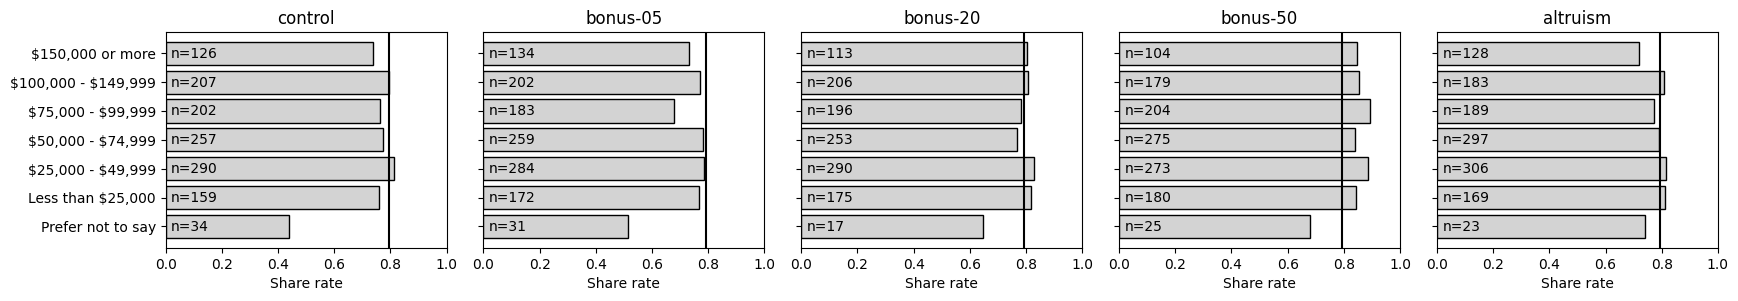

In [37]:
print(Q)
formula = "share ~ C(income)"
print(formula)

figsize = (3.25, 2.75)
# plot horizontally all together
fig, axes = plt.subplots(1,5,figsize=(figsize[0]*5, figsize[1]), sharey=True)
plt.tight_layout()

for i, incentive in enumerate(incentives_list):
    # restrict data to incentive
    incentive_df = df[df['incentive']==incentive].copy()
    # give demo a short name from Q
    incentive_df['income'] = incentive_df[Q]
    print('------- %s -------' % incentive)
    income_share_df = get_share_rate_by_Q_df(Q, colname, df=incentive_df)
    # order by income
    income_share_df = income_share_df.set_index('income').loc[income_order].reset_index()
    #display(income_share_df)
    # plot horizontally with the others
    plot_share_by_demo(income_share_df, colname, axes[i])
    axes[i].set_title(incentive)
    # plot alone
    #fig, ax = plt.subplots(1,1,figsize=figsize)
    #plot_share_by_demo(income_share_df, colname, ax)
    #ax.set_title(incentive)
    model = smf.logit(formula=formula, data=incentive_df).fit()
    display(model.summary2())
    #display(get_predictors_table(model))
    
    
plt.show()


#### Evaluate each income group separately

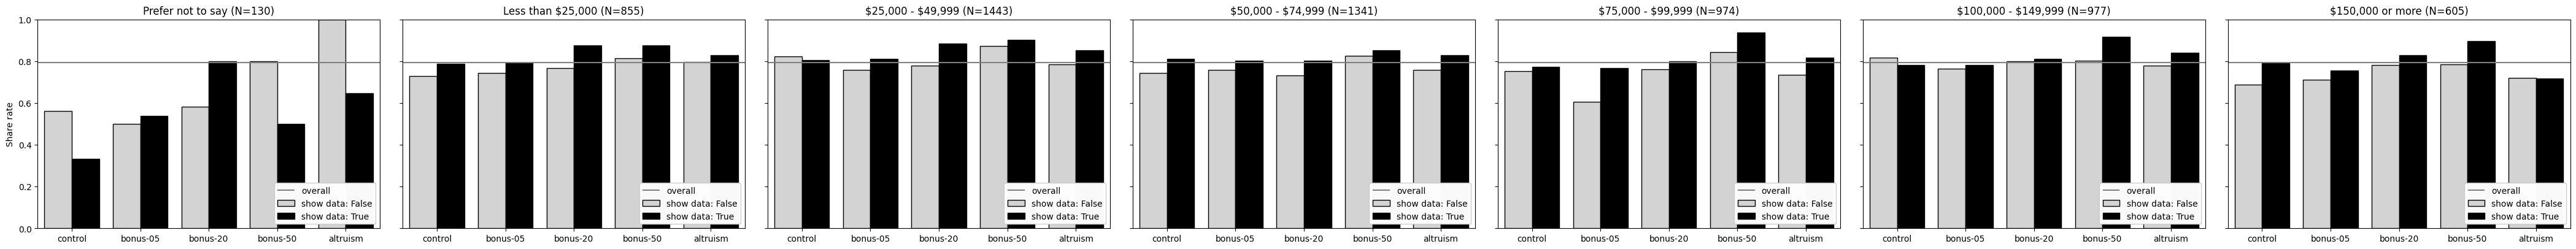

In [38]:
figsize=(6,4)
fig,axes = plt.subplots(1,7,figsize=(figsize[0]*7,figsize[1]), sharey=True)
plt.tight_layout()
for i, income in enumerate(income_order):
    demo_df = df[df[Q]==income]
    demo_agg_share_df = get_aggregate_share_df(demo_df)
    plot_share_rate(demo_agg_share_df, axes[i])
    axes[i].set_title('%s (N=%s)' % (income, len(demo_df)))

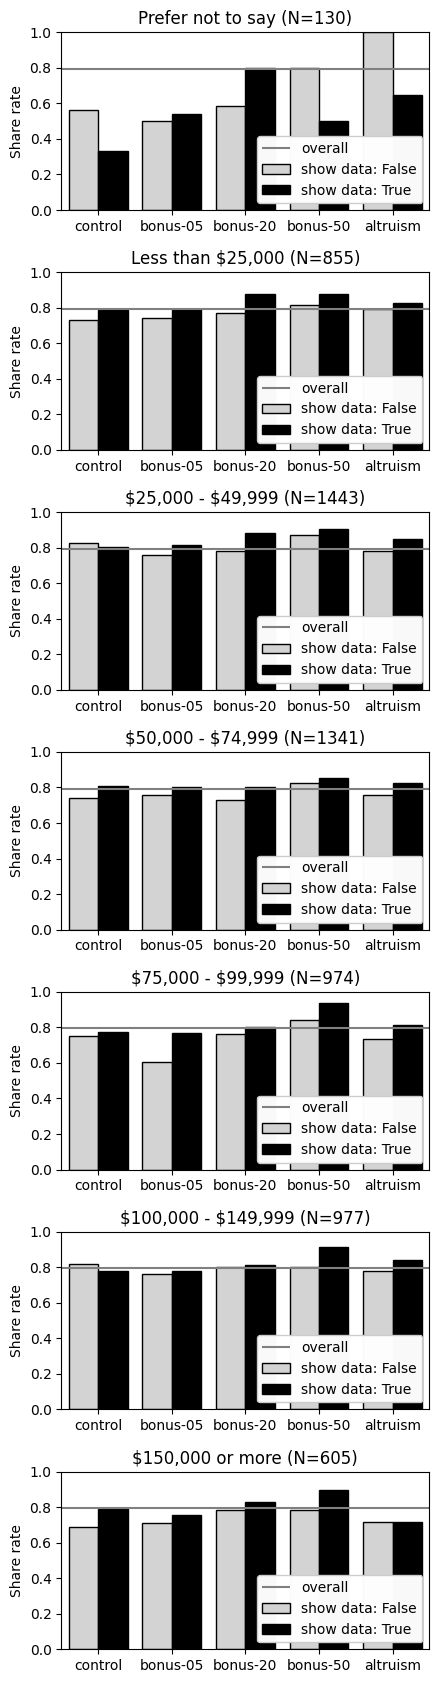

In [39]:
figsize=(4.75,3)
fig,axes = plt.subplots(7,1,figsize=(figsize[0],figsize[1]*7))
plt.subplots_adjust(hspace=0.35)
for i, income in enumerate(income_order):
    demo_df = df[df[Q]==income]
    demo_agg_share_df = get_aggregate_share_df(demo_df)
    plot_share_rate(demo_agg_share_df, axes[i])
    axes[i].set_title('%s (N=%s)' % (income, len(demo_df)))

In [40]:
# Logistic reggressions to test for differences
formula = "share ~ C(incentive, Treatment(reference='control')) + showdata"
for i, income in enumerate(income_order):
    print('------- Income group: %s -------' % income)
    print(formula)
    demo_df = df[df[Q]==income]
    model = smf.logit(formula=formula, data=demo_df).fit()
    display(model.summary2())
    display(get_predictors_table(model))

------- Income group: Prefer not to say -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.641577
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                            Logit                         Pseudo R-squared:              0.055   
Dependent Variable:               share                         AIC:                           178.8100
Date:                             2023-05-09 14:06              BIC:                           196.0152
No. Observations:                 130                           Log-Likelihood:                -83.405 
Df Model:                         5                             LL-Null:                       -88.239 
Df Residuals:                     124                           LLR p-value:                   0.085232
Converged:                        1.0000                        Scale:                         1.0000  
No. Iterations:                   5.0000                                                               
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 0.0855   0.4013  0.2130 0.8314 -0.7010 0.8719
C(incentive, Treatment(reference='control'))[T.altruism]  1.4309   0.6020  2.3768 0.0175  0.2509 2.6108
C(incentive, Treatment(reference='control'))[T.bonus-05]  0.2390   0.5055  0.4728 0.6364 -0.7518 1.2299
C(incentive, Treatment(reference='control'))[T.bonus-20]  0.7128   0.6244  1.1416 0.2536 -0.5110 1.9366
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.9315   0.5571  1.6721 0.0945 -0.1603 2.0234
showdata[T.True]                                         -0.6181   0.3849 -1.6059 0.1083 -1.3724 0.1363
=======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,0.085,1.089,"[0.496, 2.391]",0.831
"C(incentive, Treatment(reference='control'))[T.altruism]",1.431,4.182,"[1.285, 13.610]",0.017
"C(incentive, Treatment(reference='control'))[T.bonus-05]",0.239,1.270,"[0.471, 3.421]",0.636
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.713,2.040,"[0.600, 6.935]",0.254
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.932,2.538,"[0.852, 7.564]",0.094
showdata[T.True],-0.618,0.539,"[0.254, 1.146]",0.108


------- Income group: Less than \$25,000 -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.492632
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                           Results: Logit
=====================================================================================================
Model:                            Logit                        Pseudo R-squared:             0.012   
Dependent Variable:               share                        AIC:                          854.4000
Date:                             2023-05-09 14:06             BIC:                          882.9066
No. Observations:                 855                          Log-Likelihood:               -421.20 
Df Model:                         5                            LL-Null:                      -426.45 
Df Residuals:                     849                          LLR p-value:                  0.062051
Converged:                        1.0000                       Scale:                        1.0000  
No. Iterations:                   6.0000                                                             
-----------------------------------------------------------------------------------------------------
                                                         Coef.  Std.Err.   z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------------------------------------------
Intercept                                                0.9476   0.2067 4.5850 0.0000  0.5425 1.3527
C(incentive, Treatment(reference='control'))[T.altruism] 0.3298   0.2718 1.2136 0.2249 -0.2028 0.8624
C(incentive, Treatment(reference='control'))[T.bonus-05] 0.0688   0.2605 0.2643 0.7916 -0.4417 0.5793
C(incentive, Treatment(reference='control'))[T.bonus-20] 0.3816   0.2714 1.4057 0.1598 -0.1504 0.9136
C(incentive, Treatment(reference='control'))[T.bonus-50] 0.5626   0.2785 2.0204 0.0433  0.0168 1.1083
showdata[T.True]                                         0.3940   0.1744 2.2591 0.0239  0.0522 0.7359
=====================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,0.948,2.580,"[1.720, 3.868]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.330,1.391,"[0.816, 2.369]",0.225
"C(incentive, Treatment(reference='control'))[T.bonus-05]",0.069,1.071,"[0.643, 1.785]",0.792
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.382,1.465,"[0.860, 2.493]",0.160
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.563,1.755,"[1.017, 3.029]",0.043
showdata[T.True],0.394,1.483,"[1.054, 2.087]",0.024


------- Income group: \$25,000 - \$49,999 -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.457193
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                           Logit                         Pseudo R-squared:              0.013    
Dependent Variable:              share                         AIC:                           1331.4578
Date:                            2023-05-09 14:06              BIC:                           1363.1047
No. Observations:                1443                          Log-Likelihood:                -659.73  
Df Model:                        5                             LL-Null:                       -668.34  
Df Residuals:                    1437                          LLR p-value:                   0.0040884
Converged:                       1.0000                        Scale:                         1.0000   
No. Iterations:                  6.0000                                                                
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 1.3157   0.1634  8.0536 0.0000  0.9955 1.6359
C(incentive, Treatment(reference='control'))[T.altruism]  0.0179   0.2117  0.0845 0.9326 -0.3970 0.4328
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.1841   0.2094 -0.8794 0.3792 -0.5945 0.2263
C(incentive, Treatment(reference='control'))[T.bonus-20]  0.1012   0.2171  0.4661 0.6411 -0.3243 0.5267
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.5953   0.2437  2.4427 0.0146  0.1176 1.0730
showdata[T.True]                                          0.3413   0.1408  2.4233 0.0154  0.0653 0.6173
=======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.316,3.727,"[2.706, 5.134]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.018,1.018,"[0.672, 1.542]",0.933
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.184,0.832,"[0.552, 1.254]",0.379
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.101,1.106,"[0.723, 1.693]",0.641
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.595,1.814,"[1.125, 2.924]",0.015
showdata[T.True],0.341,1.407,"[1.067, 1.854]",0.015


------- Income group: \$50,000 - \$74,999 -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.507915
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                           Logit                         Pseudo R-squared:              0.009    
Dependent Variable:              share                         AIC:                           1374.2267
Date:                            2023-05-09 14:06              BIC:                           1405.4338
No. Observations:                1341                          Log-Likelihood:                -681.11  
Df Model:                        5                             LL-Null:                       -687.08  
Df Residuals:                    1335                          LLR p-value:                   0.035800 
Converged:                       1.0000                        Scale:                         1.0000   
No. Iterations:                  6.0000                                                                
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 1.0821   0.1603  6.7488 0.0000  0.7678 1.3964
C(incentive, Treatment(reference='control'))[T.altruism]  0.1010   0.2070  0.4879 0.6256 -0.3047 0.5067
C(incentive, Treatment(reference='control'))[T.bonus-05]  0.0208   0.2121  0.0979 0.9220 -0.3950 0.4365
C(incentive, Treatment(reference='control'))[T.bonus-20] -0.0519   0.2112 -0.2457 0.8059 -0.4658 0.3621
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.4107   0.2226  1.8447 0.0651 -0.0257 0.8470
showdata[T.True]                                          0.3367   0.1360  2.4764 0.0133  0.0702 0.6031
=======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.082,2.951,"[2.155, 4.040]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.101,1.106,"[0.737, 1.660]",0.626
"C(incentive, Treatment(reference='control'))[T.bonus-05]",0.021,1.021,"[0.674, 1.547]",0.922
"C(incentive, Treatment(reference='control'))[T.bonus-20]",-0.052,0.949,"[0.628, 1.436]",0.806
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.411,1.508,"[0.975, 2.333]",0.065
showdata[T.True],0.337,1.400,"[1.073, 1.828]",0.013


------- Income group: \$75,000 - \$99,999 -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.508849
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                            Logit                        Pseudo R-squared:             0.036     
Dependent Variable:               share                        AIC:                          1003.2375 
Date:                             2023-05-09 14:06             BIC:                          1032.5260 
No. Observations:                 974                          Log-Likelihood:               -495.62   
Df Model:                         5                            LL-Null:                      -514.12   
Df Residuals:                     968                          LLR p-value:                  5.9932e-07
Converged:                        1.0000                       Scale:                        1.0000    
No. Iterations:                   6.0000                                                               
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 0.9538   0.1791  5.3260 0.0000  0.6028 1.3047
C(incentive, Treatment(reference='control'))[T.altruism]  0.0665   0.2408  0.2762 0.7824 -0.4055 0.5385
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.4125   0.2300 -1.7934 0.0729 -0.8634 0.0383
C(incentive, Treatment(reference='control'))[T.bonus-20]  0.1024   0.2401  0.4263 0.6699 -0.3683 0.5730
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.9288   0.2808  3.3081 0.0009  0.3785 1.4791
showdata[T.True]                                          0.4719   0.1599  2.9515 0.0032  0.1585 0.7852
=======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,0.954,2.595,"[1.827, 3.687]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.067,1.069,"[0.667, 1.714]",0.782
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.413,0.662,"[0.422, 1.039]",0.073
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.102,1.108,"[0.692, 1.774]",0.670
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.929,2.532,"[1.460, 4.389]",0.001
showdata[T.True],0.472,1.603,"[1.172, 2.193]",0.003


------- Income group: \$100,000 - \$149,999 -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.488156
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                            Logit                         Pseudo R-squared:              0.006   
Dependent Variable:               share                         AIC:                           965.8571
Date:                             2023-05-09 14:06              BIC:                           995.1640
No. Observations:                 977                           Log-Likelihood:                -476.93 
Df Model:                         5                             LL-Null:                       -479.89 
Df Residuals:                     971                           LLR p-value:                   0.31403 
Converged:                        1.0000                        Scale:                         1.0000  
No. Iterations:                   6.0000                                                               
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 1.2670   0.1910  6.6340 0.0000  0.8927 1.6413
C(incentive, Treatment(reference='control'))[T.altruism]  0.0773   0.2556  0.3026 0.7622 -0.4235 0.5782
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.1460   0.2411 -0.6055 0.5449 -0.6185 0.3265
C(incentive, Treatment(reference='control'))[T.bonus-20]  0.0621   0.2470  0.2514 0.8015 -0.4221 0.5463
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.4171   0.2740  1.5219 0.1280 -0.1200 0.9541
showdata[T.True]                                          0.1978   0.1629  1.2147 0.2245 -0.1214 0.5170
=======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.267,3.550,"[2.442, 5.162]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.077,1.080,"[0.655, 1.783]",0.762
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.146,0.864,"[0.539, 1.386]",0.545
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.062,1.064,"[0.656, 1.727]",0.802
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.417,1.517,"[0.887, 2.596]",0.128
showdata[T.True],0.198,1.219,"[0.886, 1.677]",0.224


------- Income group: \$150,000 or more -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.537824
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                            Logit                         Pseudo R-squared:              0.017   
Dependent Variable:               share                         AIC:                           662.7670
Date:                             2023-05-09 14:06              BIC:                           689.1983
No. Observations:                 605                           Log-Likelihood:                -325.38 
Df Model:                         5                             LL-Null:                       -330.85 
Df Residuals:                     599                           LLR p-value:                   0.052909
Converged:                        1.0000                        Scale:                         1.0000  
No. Iterations:                   6.0000                                                               
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 0.8803   0.2213  3.9773 0.0001  0.4465 1.3141
C(incentive, Treatment(reference='control'))[T.altruism] -0.1191   0.2834 -0.4203 0.6743 -0.6745 0.4363
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.0227   0.2820 -0.0805 0.9358 -0.5753 0.5299
C(incentive, Treatment(reference='control'))[T.bonus-20]  0.3785   0.3130  1.2095 0.2265 -0.2349 0.9920
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.6498   0.3398  1.9123 0.0558 -0.0162 1.3159
showdata[T.True]                                          0.3297   0.1941  1.6991 0.0893 -0.0506 0.7101
=======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,0.880,2.412,"[1.563, 3.722]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",-0.119,0.888,"[0.509, 1.547]",0.674
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.023,0.978,"[0.563, 1.699]",0.936
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.379,1.460,"[0.791, 2.697]",0.226
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.650,1.915,"[0.984, 3.728]",0.056
showdata[T.True],0.330,1.391,"[0.951, 2.034]",0.089


Income group: Prefer not to say
- Altruism incentive had statistically significant positive impact on sharing (not the case for other groups)
- Other incentives: no significant difference

For higher income groups: $100k +
- Showdata had no significant effect
- Bonuses had no significant effect

Overall difficult to draw clear conclusions about the relationship between income group and incentives

### By age group

Overall

What is your age group?


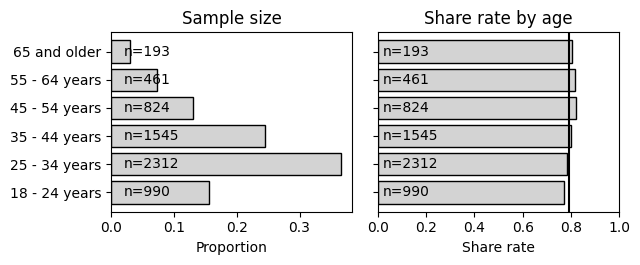

,age,n,share rate
0,18 - 24 years,990,0.773
1,25 - 34 years,2312,0.784
2,35 - 44 years,1545,0.801
3,45 - 54 years,824,0.820
4,55 - 64 years,461,0.818
5,65 and older,193,0.803


In [78]:
Q = 'q-demos-age'
print(fields_df.loc[Q][0])
age_df = df[Q].value_counts().rename('survey N').to_frame().sort_index()
age_df['survey proportion'] = age_df['survey N']/age_df['survey N'].sum()
figsize = (3.25, 2.75)
fig, axes = plt.subplots(1,2,figsize=(figsize[0]*2,figsize[1]), dpi=100, sharey=True)
plt.tight_layout()
plot_survey_proportion_with_N(age_df, axes[0])
axes[0].set_title('Sample size')
colname = 'age'
age_share_df = get_share_rate_by_Q_df(Q, colname)
plot_share_by_demo(age_share_df, colname, axes[1])
plt.tight_layout()
plt.show()
age_share_df

#### Evaluate each incentive separately

q-demos-age
share ~ C(age)
------- control -------
Optimization terminated successfully.
         Current function value: 0.533618
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
====================================================================
Model:                Logit             Pseudo R-squared:  0.008    
Dependent Variable:   share             AIC:               1372.7262
Date:                 2023-05-09 14:49  BIC:               1403.6304
No. Observations:     1275              Log-Likelihood:    -680.36  
Df Model:             5                 LL-Null:           -686.06  
Df Residuals:         1269              LLR p-value:       0.043988 
Converged:            1.0000            Scale:             1.0000   
No. Iterations:       6.0000                                        
--------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z|   [0.025 0.975]
--------------------------------------------------------------------
Intercept               0.8216   0.1524 5.3918 0.0000  0.5230 1.1203
C(age)[T.25 - 34 years] 0.3968   0.1871 2.1209 0.0339  0.0301 0.7635
C(age)[T.35 - 44 years] 0.6349   0.2136 2.9718 0.0030  0.2162 1.0536
C(age)[T.45 - 54 years] 0.4127   0.2373 1.7387 0.0821 -0.0525 0.8778
C(age)[T.55 - 64 years] 0.3385   0.2929 1.1560 0.2477 -0.2354 0.9125
C(age)[T.65 and older]  1.0654   0.5035 2.1160 0.0343  0.0786 2.0523
====================================================================

"""

------- bonus-05 -------
Optimization terminated successfully.
         Current function value: 0.558034
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
======================================================================
Model:                Logit              Pseudo R-squared:   0.004    
Dependent Variable:   share              AIC:                1423.8254
Date:                 2023-05-09 14:49   BIC:                1454.6824
No. Observations:     1265               Log-Likelihood:     -705.91  
Df Model:             5                  LL-Null:            -708.87  
Df Residuals:         1259               LLR p-value:        0.31434  
Converged:            1.0000             Scale:              1.0000   
No. Iterations:       5.0000                                          
----------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
----------------------------------------------------------------------
Intercept                1.2252   0.1755  6.9808 0.0000  0.8812 1.5692
C(age)[T.25 - 34 years] -0.2375   0.2040 -1.1642 0.2443 -0.6373 0.1623
C(age)[T.35 - 44 years] -0.1100   0.2177 -0.5054 0.6133 -0.5368 0.3167
C(age)[T.45 - 54 years]  0.0191   0.2621  0.0731 0.9418 -0.4945 0.5328
C(age)[T.55 - 64 years]  0.2371   0.3092  0.7667 0.4432 -0.3690 0.8432
C(age)[T.65 and older]  -0.5746   0.3970 -1.4473 0.1478 -1.3527 0.2035
======================================================================

"""

------- bonus-20 -------
Optimization terminated successfully.
         Current function value: 0.500186
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
====================================================================
Model:                Logit             Pseudo R-squared:  0.005    
Dependent Variable:   share             AIC:               1262.4649
Date:                 2023-05-09 14:49  BIC:               1293.2503
No. Observations:     1250              Log-Likelihood:    -625.23  
Df Model:             5                 LL-Null:           -628.27  
Df Residuals:         1244              LLR p-value:       0.29981  
Converged:            1.0000            Scale:             1.0000   
No. Iterations:       6.0000                                        
--------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z|   [0.025 0.975]
--------------------------------------------------------------------
Intercept               1.2493   0.1772 7.0519 0.0000  0.9021 1.5965
C(age)[T.25 - 34 years] 0.0435   0.2107 0.2064 0.8364 -0.3694 0.4564
C(age)[T.35 - 44 years] 0.1058   0.2252 0.4696 0.6387 -0.3357 0.5472
C(age)[T.45 - 54 years] 0.4624   0.2771 1.6688 0.0952 -0.0807 1.0056
C(age)[T.55 - 64 years] 0.0945   0.3185 0.2966 0.7668 -0.5298 0.7187
C(age)[T.65 and older]  0.8609   0.5583 1.5421 0.1230 -0.2333 1.9552
====================================================================

"""

------- bonus-50 -------
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
======================================================================
Model:                Logit              Pseudo R-squared:   0.006    
Dependent Variable:   share              AIC:                1015.0827
Date:                 2023-05-09 14:49   BIC:                1045.8199
No. Observations:     1240               Log-Likelihood:     -501.54  
Df Model:             5                  LL-Null:            -504.69  
Df Residuals:         1234               LLR p-value:        0.27843  
Converged:            1.0000             Scale:              1.0000   
No. Iterations:       6.0000                                          
----------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
----------------------------------------------------------------------
Intercept                1.6659   0.1958  8.5061 0.0000  1.2820 2.0497
C(age)[T.25 - 34 years]  0.0029   0.2342  0.0123 0.9902 -0.4562 0.4620
C(age)[T.35 - 44 years]  0.2395   0.2651  0.9037 0.3662 -0.2800 0.7591
C(age)[T.45 - 54 years]  0.3585   0.3037  1.1803 0.2379 -0.2368 0.9538
C(age)[T.55 - 64 years]  0.7206   0.4182  1.7233 0.0848 -0.0990 1.5401
C(age)[T.65 and older]  -0.1778   0.4620 -0.3848 0.7004 -1.0834 0.7278
======================================================================

"""

------- altruism -------
Optimization terminated successfully.
         Current function value: 0.511660
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
======================================================================
Model:                Logit              Pseudo R-squared:   0.001    
Dependent Variable:   share              AIC:                1337.2006
Date:                 2023-05-09 14:49   BIC:                1368.1982
No. Observations:     1295               Log-Likelihood:     -662.60  
Df Model:             5                  LL-Null:            -662.98  
Df Residuals:         1289               LLR p-value:        0.97938  
Converged:            1.0000             Scale:              1.0000   
No. Iterations:       5.0000                                          
----------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
----------------------------------------------------------------------
Intercept                1.2672   0.1617  7.8357 0.0000  0.9503 1.5842
C(age)[T.25 - 34 years]  0.0863   0.1992  0.4331 0.6650 -0.3042 0.4767
C(age)[T.35 - 44 years]  0.0283   0.2094  0.1349 0.8927 -0.3822 0.4387
C(age)[T.45 - 54 years]  0.1964   0.2648  0.7414 0.4584 -0.3227 0.7154
C(age)[T.55 - 64 years]  0.1191   0.3092  0.3851 0.7002 -0.4869 0.7251
C(age)[T.65 and older]  -0.0145   0.3934 -0.0368 0.9707 -0.7854 0.7565
======================================================================

"""

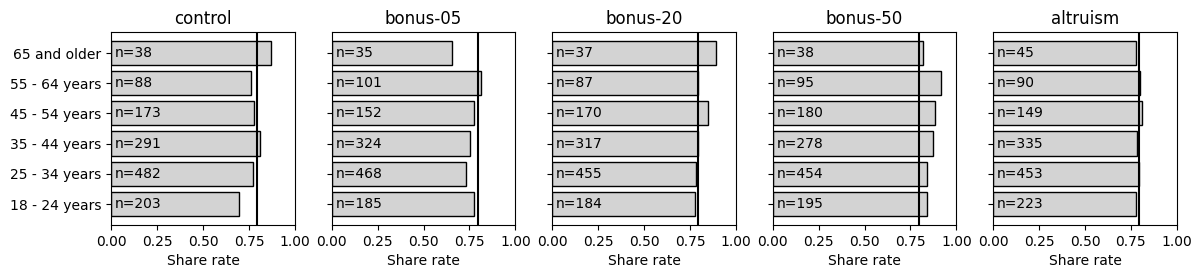

In [79]:
print(Q)
formula = "share ~ C(age)"
print(formula)

figsize = (2.75, 2.5)
# plot horizontally all together
fig, axes = plt.subplots(1,5,figsize=(figsize[0]*5, figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0.2)
# plt.tight_layout()

for i, incentive in enumerate(incentives_list):
    # restrict data to incentive
    incentive_df = df[df['incentive']==incentive].copy()
    # give demo a short name from Q
    incentive_df['age'] = incentive_df[Q]
    print('------- %s -------' % incentive)
    age_share_df = get_share_rate_by_Q_df(Q, colname, df=incentive_df)
    # plot horizontally with the others
    plot_share_by_demo(age_share_df, colname, axes[i])
    axes[i].set_title(incentive)
    model = smf.logit(formula=formula, data=incentive_df).fit()
    display(model.summary2())
    #display(get_predictors_table(model))
    
plt.show()

#### Evaluating age groups separately

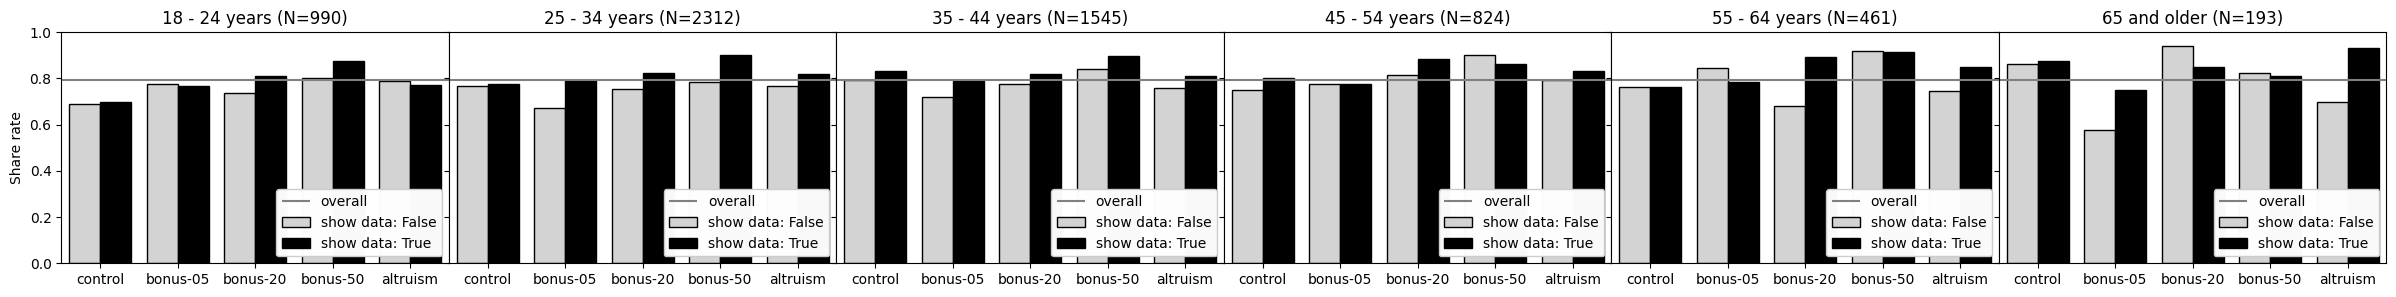

In [80]:
figsize=(5,3)
fig,axes = plt.subplots(1,6,figsize=(figsize[0]*6,figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0)
for i, age in enumerate(age_df.index.to_list()):
    demo_df = df[df[Q]==age]
    demo_agg_share_df = get_aggregate_share_df(demo_df)
    plot_share_rate(demo_agg_share_df, axes[i])
    axes[i].set_title('%s (N=%s)' % (age, len(demo_df)))

In [81]:
# Logistic reggressions to test for differences
formula = "share ~ C(incentive, Treatment(reference='control')) + showdata"
for i, age in enumerate(age_df.index.to_list()):
    print('------- Age group: %s -------' % age)
    print(formula)
    demo_df = df[df[Q]==age]
    model = smf.logit(formula=formula, data=demo_df).fit()
    display(model.summary2())
    #display(get_predictors_table(model))

------- Age group: 18 - 24 years -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.529383
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                           Results: Logit
=====================================================================================================
Model:                           Logit                        Pseudo R-squared:             0.012    
Dependent Variable:              share                        AIC:                          1060.1790
Date:                            2023-05-09 14:49             BIC:                          1089.5652
No. Observations:                990                          Log-Likelihood:               -524.09  
Df Model:                        5                            LL-Null:                      -530.60  
Df Residuals:                    984                          LLR p-value:                  0.023177 
Converged:                       1.0000                       Scale:                        1.0000   
No. Iterations:                  6.0000                                                              
-----------------------------------------------------------------------------------------------------
                                                         Coef.  Std.Err.   z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------------------------------------------
Intercept                                                0.7543   0.1712 4.4050 0.0000  0.4187 1.0900
C(incentive, Treatment(reference='control'))[T.altruism] 0.4556   0.2226 2.0464 0.0407  0.0192 0.8919
C(incentive, Treatment(reference='control'))[T.bonus-05] 0.4050   0.2325 1.7417 0.0816 -0.0507 0.8608
C(incentive, Treatment(reference='control'))[T.bonus-20] 0.4252   0.2338 1.8188 0.0689 -0.0330 0.8834
C(incentive, Treatment(reference='control'))[T.bonus-50] 0.8441   0.2482 3.4004 0.0007  0.3576 1.3306
showdata[T.True]                                         0.1305   0.1531 0.8523 0.3941 -0.1696 0.4305
=====================================================================================================

"""

------- Age group: 25 - 34 years -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.514292
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                            Logit                        Pseudo R-squared:             0.015     
Dependent Variable:               share                        AIC:                          2390.0882 
Date:                             2023-05-09 14:49             BIC:                          2424.5634 
No. Observations:                 2312                         Log-Likelihood:               -1189.0   
Df Model:                         5                            LL-Null:                      -1207.2   
Df Residuals:                     2306                         LLR p-value:                  8.3695e-07
Converged:                        1.0000                       Scale:                        1.0000    
No. Iterations:                   6.0000                                                               
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 0.9994   0.1195  8.3663 0.0000  0.7652 1.2335
C(incentive, Treatment(reference='control'))[T.altruism]  0.1425   0.1597  0.8920 0.3724 -0.1706 0.4556
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.1997   0.1511 -1.3216 0.1863 -0.4958 0.0965
C(incentive, Treatment(reference='control'))[T.bonus-20]  0.1080   0.1583  0.6824 0.4950 -0.2022 0.4182
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.4748   0.1689  2.8109 0.0049  0.1437 0.8058
showdata[T.True]                                          0.4348   0.1031  4.2187 0.0000  0.2328 0.6368
=======================================================================================================

"""

------- Age group: 35 - 44 years -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.492569
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                            Logit                        Pseudo R-squared:             0.014     
Dependent Variable:               share                        AIC:                          1534.0396 
Date:                             2023-05-09 14:49             BIC:                          1566.0963 
No. Observations:                 1545                         Log-Likelihood:               -761.02   
Df Model:                         5                            LL-Null:                      -771.73   
Df Residuals:                     1539                         LLR p-value:                  0.00067249
Converged:                        1.0000                       Scale:                        1.0000    
No. Iterations:                   6.0000                                                               
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 1.3063   0.1595  8.1900 0.0000  0.9937 1.6189
C(incentive, Treatment(reference='control'))[T.altruism] -0.1781   0.2008 -0.8870 0.3751 -0.5718 0.2155
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.3518   0.1980 -1.7763 0.0757 -0.7399 0.0364
C(incentive, Treatment(reference='control'))[T.bonus-20] -0.1017   0.2048 -0.4963 0.6197 -0.5031 0.2998
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.4420   0.2335  1.8927 0.0584 -0.0157 0.8997
showdata[T.True]                                          0.3378   0.1292  2.6142 0.0089  0.0845 0.5911
=======================================================================================================

"""

------- Age group: 45 - 54 years -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.463921
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                           Results: Logit
=====================================================================================================
Model:                            Logit                        Pseudo R-squared:             0.015   
Dependent Variable:               share                        AIC:                          776.5426
Date:                             2023-05-09 14:49             BIC:                          804.8276
No. Observations:                 824                          Log-Likelihood:               -382.27 
Df Model:                         5                            LL-Null:                      -387.94 
Df Residuals:                     818                          LLR p-value:                  0.044995
Converged:                        1.0000                       Scale:                        1.0000  
No. Iterations:                   6.0000                                                             
-----------------------------------------------------------------------------------------------------
                                                         Coef.  Std.Err.   z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------------------------------------------
Intercept                                                1.1584   0.1996 5.8040 0.0000  0.7672 1.5496
C(incentive, Treatment(reference='control'))[T.altruism] 0.2282   0.2778 0.8214 0.4114 -0.3163 0.7727
C(incentive, Treatment(reference='control'))[T.bonus-05] 0.0048   0.2667 0.0179 0.9857 -0.5179 0.5274
C(incentive, Treatment(reference='control'))[T.bonus-20] 0.4785   0.2803 1.7069 0.0878 -0.0709 1.0280
C(incentive, Treatment(reference='control'))[T.bonus-50] 0.7874   0.2951 2.6682 0.0076  0.2090 1.3658
showdata[T.True]                                         0.1661   0.1836 0.9049 0.3655 -0.1937 0.5260
=====================================================================================================

"""

------- Age group: 55 - 64 years -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.462418
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                           Results: Logit
=====================================================================================================
Model:                            Logit                        Pseudo R-squared:             0.026   
Dependent Variable:               share                        AIC:                          438.3491
Date:                             2023-05-09 14:49             BIC:                          463.1495
No. Observations:                 461                          Log-Likelihood:               -213.17 
Df Model:                         5                            LL-Null:                      -218.85 
Df Residuals:                     455                          LLR p-value:                  0.044800
Converged:                        1.0000                       Scale:                        1.0000  
No. Iterations:                   6.0000                                                             
-----------------------------------------------------------------------------------------------------
                                                         Coef.  Std.Err.   z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------------------------------------------
Intercept                                                1.0145   0.2724 3.7238 0.0002  0.4805 1.5484
C(incentive, Treatment(reference='control'))[T.altruism] 0.2128   0.3642 0.5842 0.5591 -0.5011 0.9266
C(incentive, Treatment(reference='control'))[T.bonus-05] 0.2787   0.3581 0.7783 0.4364 -0.4231 0.9805
C(incentive, Treatment(reference='control'))[T.bonus-20] 0.1679   0.3651 0.4599 0.6456 -0.5477 0.8835
C(incentive, Treatment(reference='control'))[T.bonus-50] 1.2280   0.4468 2.7485 0.0060  0.3523 2.1036
showdata[T.True]                                         0.3192   0.2450 1.3027 0.1927 -0.1610 0.7994
=====================================================================================================

"""

------- Age group: 65 and older -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.473242
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                             Results: Logit
========================================================================================================
Model:                             Logit                         Pseudo R-squared:              0.046   
Dependent Variable:                share                         AIC:                           194.6715
Date:                              2023-05-09 14:49              BIC:                           214.2477
No. Observations:                  193                           Log-Likelihood:                -91.336 
Df Model:                          5                             LL-Null:                       -95.740 
Df Residuals:                      187                           LLR p-value:                   0.11695 
Converged:                         1.0000                        Scale:                         1.0000  
No. Iterations:                    6.0000                                                               
--------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                                 1.7234   0.4991  3.4527 0.0006  0.7451  2.7017
C(incentive, Treatment(reference='control'))[T.altruism] -0.6017   0.6012 -1.0009 0.3169 -1.7801  0.5766
C(incentive, Treatment(reference='control'))[T.bonus-05] -1.2609   0.6003 -2.1003 0.0357 -2.4375 -0.0843
C(incentive, Treatment(reference='control'))[T.bonus-20]  0.1737   0.7175  0.2421 0.8087 -1.2325  1.5800
C(incentive, Treatment(reference='control'))[T.bonus-50] -0.4571   0.6408 -0.7134 0.4756 -1.7131  0.7988
showdata[T.True]                                          0.4272   0.3852  1.1092 0.2673 -0.3277  1.1821
========================================================================================================

"""

### By education

In [82]:
education_order = ['Prefer not to say', 'Some high school or less', 'High school diploma or GED', 
                   "Bachelor's degree", 'Graduate or professional degree']

Overall

What is the highest level of education you have completed?


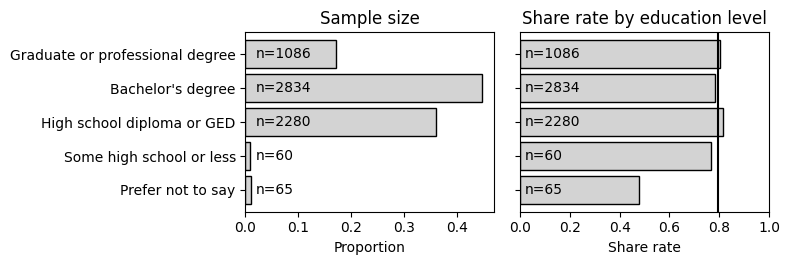

,education level,n,share rate
0,Prefer not to say,65,0.477
1,Some high school or less,60,0.767
2,High school diploma or GED,2280,0.816
3,Bachelor's degree,2834,0.781
4,Graduate or professional degree,1086,0.802


In [83]:
Q = 'Q-demos-education'
print(fields_df.loc[Q][0])
edu_df = df[Q].value_counts().rename('survey N').to_frame().loc[education_order] # sort by order defined
edu_df['survey proportion'] = edu_df['survey N']/edu_df['survey N'].sum()
figsize = (4, 2.75)
fig, axes = plt.subplots(1,2,figsize=(figsize[0]*2,figsize[1]), dpi=100, sharey=True)
plt.tight_layout()
plot_survey_proportion_with_N(edu_df, axes[0])
axes[0].set_title('Sample size')
colname = 'education level'
edu_share_df = get_share_rate_by_Q_df(Q, colname).set_index(colname).loc[education_order].reset_index()
plot_share_by_demo(edu_share_df, colname, axes[1])
plt.tight_layout()
plt.show()
edu_share_df

#### Evaluate each incentive separately

Q-demos-education
share ~ C(edu)
------- control -------
         Current function value: 0.529073
         Iterations: 35


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                             Results: Logit
========================================================================================================
Model:                           Logit                         Pseudo R-squared:              0.017     
Dependent Variable:              share                         AIC:                           1359.1360 
Date:                            2023-05-09 14:49              BIC:                           1384.8895 
No. Observations:                1275                          Log-Likelihood:                -674.57   
Df Model:                        4                             LL-Null:                       -686.06   
Df Residuals:                    1270                          LLR p-value:                   0.00012715
Converged:                       0.0000                        Scale:                         1.0000    
No. Iterations:                  35.0000                                                                
--------------------------------------------------------------------------------------------------------
                                           Coef.    Std.Err.      z    P>|z|      [0.025       0.975]   
--------------------------------------------------------------------------------------------------------
Intercept                                  1.1826       0.0977 12.1098 0.0000        0.9912       1.3740
C(edu)[T.Graduate or professional degree]  0.1768       0.1905  0.9280 0.3534       -0.1965       0.5501
C(edu)[T.High school diploma or GED]       0.0762       0.1523  0.5006 0.6166       -0.2223       0.3748
C(edu)[T.Prefer not to say]               -1.6244       0.4383 -3.7065 0.0002       -2.4834      -0.7654
C(edu)[T.Some high school or less]        29.1594 1076397.3427  0.0000 1.0000 -2109670.8653 2109729.1841
========================================================================================================

"""

------- bonus-05 -------
Optimization terminated successfully.
         Current function value: 0.551990
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                     Results: Logit
=========================================================================================
Model:                      Logit                    Pseudo R-squared:         0.015     
Dependent Variable:         share                    AIC:                      1406.5350 
Date:                       2023-05-09 14:49         BIC:                      1432.2491 
No. Observations:           1265                     Log-Likelihood:           -698.27   
Df Model:                   4                        LL-Null:                  -708.87   
Df Residuals:               1260                     LLR p-value:              0.00028800
Converged:                  1.0000                   Scale:                    1.0000    
No. Iterations:             6.0000                                                       
-----------------------------------------------------------------------------------------
                                           Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------------
Intercept                                  0.9663   0.0941 10.2721 0.0000  0.7819  1.1507
C(edu)[T.Graduate or professional degree]  0.1143   0.1810  0.6314 0.5278 -0.2405  0.4691
C(edu)[T.High school diploma or GED]       0.3980   0.1500  2.6536 0.0080  0.1040  0.6920
C(edu)[T.Prefer not to say]               -1.7772   0.6082 -2.9219 0.0035 -2.9694 -0.5851
C(edu)[T.Some high school or less]         1.5186   1.0451  1.4531 0.1462 -0.5297  3.5669
=========================================================================================

"""

------- bonus-20 -------
Optimization terminated successfully.
         Current function value: 0.500482
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                     Results: Logit
========================================================================================
Model:                      Logit                    Pseudo R-squared:         0.004    
Dependent Variable:         share                    AIC:                      1261.2038
Date:                       2023-05-09 14:49         BIC:                      1286.8583
No. Observations:           1250                     Log-Likelihood:           -625.60  
Df Model:                   4                        LL-Null:                  -628.27  
Df Residuals:               1245                     LLR p-value:              0.25531  
Converged:                  1.0000                   Scale:                    1.0000   
No. Iterations:             5.0000                                                      
----------------------------------------------------------------------------------------
                                           Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
----------------------------------------------------------------------------------------
Intercept                                  1.3708   0.1049 13.0708 0.0000  1.1653 1.5764
C(edu)[T.Graduate or professional degree] -0.1318   0.2042 -0.6452 0.5188 -0.5320 0.2685
C(edu)[T.High school diploma or GED]       0.1281   0.1588  0.8064 0.4200 -0.1832 0.4394
C(edu)[T.Prefer not to say]               -0.4545   0.6008 -0.7565 0.4493 -1.6321 0.7231
C(edu)[T.Some high school or less]        -0.9654   0.5374 -1.7964 0.0724 -2.0186 0.0879
========================================================================================

"""

------- bonus-50 -------
Optimization terminated successfully.
         Current function value: 0.400038
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                     Results: Logit
=========================================================================================
Model:                       Logit                    Pseudo R-squared:         0.017    
Dependent Variable:          share                    AIC:                      1002.0931
Date:                        2023-05-09 14:49         BIC:                      1027.7074
No. Observations:            1240                     Log-Likelihood:           -496.05  
Df Model:                    4                        LL-Null:                  -504.69  
Df Residuals:                1235                     LLR p-value:              0.0017005
Converged:                   1.0000                   Scale:                    1.0000   
No. Iterations:              6.0000                                                      
-----------------------------------------------------------------------------------------
                                           Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------------
Intercept                                  1.6877   0.1174 14.3778 0.0000  1.4576  1.9178
C(edu)[T.Graduate or professional degree]  0.1476   0.2290  0.6444 0.5193 -0.3012  0.5963
C(edu)[T.High school diploma or GED]       0.3674   0.1883  1.9508 0.0511 -0.0017  0.7366
C(edu)[T.Prefer not to say]               -2.6040   0.8449 -3.0822 0.0021 -4.2599 -0.9481
C(edu)[T.Some high school or less]        -0.9945   0.8739 -1.1380 0.2551 -2.7074  0.7184
=========================================================================================

"""

------- altruism -------
Optimization terminated successfully.
         Current function value: 0.510134
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                     Results: Logit
========================================================================================
Model:                      Logit                    Pseudo R-squared:         0.004    
Dependent Variable:         share                    AIC:                      1331.2464
Date:                       2023-05-09 14:49         BIC:                      1357.0777
No. Observations:           1295                     Log-Likelihood:           -660.62  
Df Model:                   4                        LL-Null:                  -662.98  
Df Residuals:               1290                     LLR p-value:              0.31765  
Converged:                  1.0000                   Scale:                    1.0000   
No. Iterations:             5.0000                                                      
----------------------------------------------------------------------------------------
                                           Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
----------------------------------------------------------------------------------------
Intercept                                  1.2494   0.1007 12.4126 0.0000  1.0521 1.4467
C(edu)[T.Graduate or professional degree]  0.3088   0.2010  1.5363 0.1245 -0.0852 0.7027
C(edu)[T.High school diploma or GED]       0.1212   0.1523  0.7956 0.4263 -0.1773 0.4197
C(edu)[T.Prefer not to say]               -0.1508   0.8227 -0.1833 0.8546 -1.7632 1.4616
C(edu)[T.Some high school or less]        -0.7794   0.5789 -1.3463 0.1782 -1.9140 0.3553
========================================================================================

"""

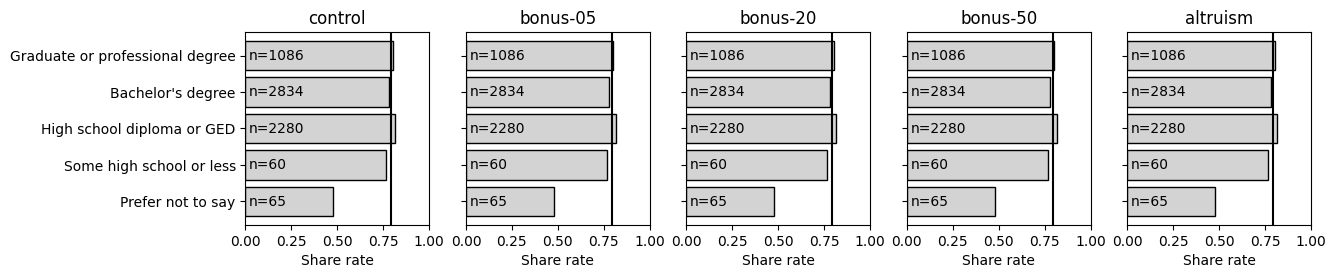

In [84]:
print(Q)
formula = "share ~ C(edu)"
print(formula)
figsize = (2.75, 2.5)
# plot horizontally all together
fig, axes = plt.subplots(1,5,figsize=(figsize[0]*5, figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0.2)
for i, incentive in enumerate(incentives_list):
    # restrict data to incentive
    incentive_df = df[df['incentive']==incentive].copy()
    # give demo a short name from Q
    incentive_df['edu'] = incentive_df[Q]
    print('------- %s -------' % incentive)
    income_share_df = get_share_rate_by_Q_df(Q, colname, df=incentive_df)
    # plot horizontally with the others
    plot_share_by_demo(edu_share_df, colname, axes[i])
    axes[i].set_title(incentive)
    model = smf.logit(formula=formula, data=incentive_df).fit()
    display(model.summary2())
    #display(get_predictors_table(model))
plt.show()

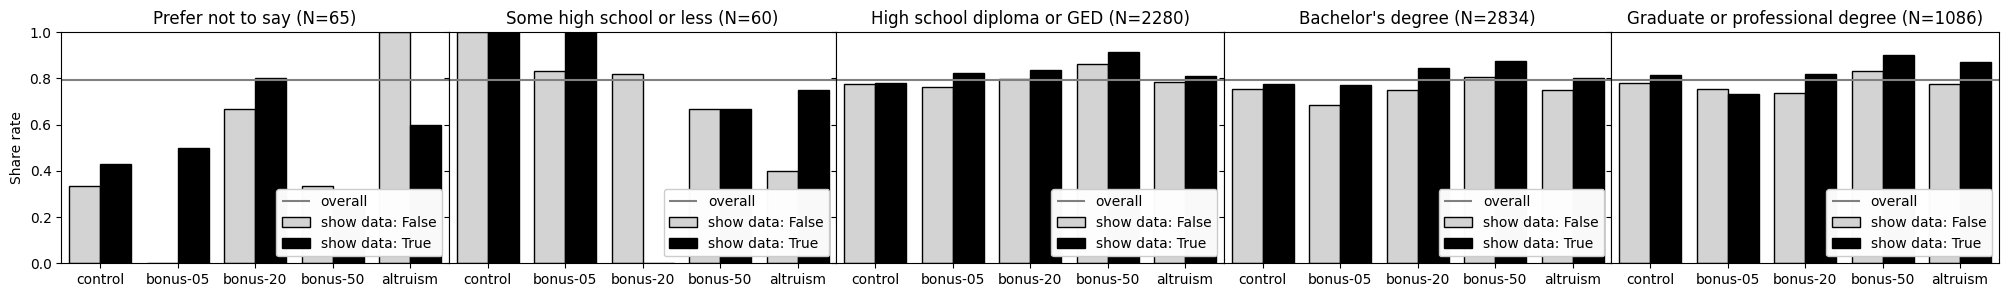

In [85]:
figsize=(5,3)
fig,axes = plt.subplots(1,5,figsize=(figsize[0]*5,figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0)
for i, edu in enumerate(education_order):
    demo_df = df[df[Q]==edu]
    demo_agg_share_df = get_aggregate_share_df(demo_df)
    plot_share_rate(demo_agg_share_df, axes[i])
    axes[i].set_title('%s (N=%s)' % (edu, len(demo_df)))

In [86]:
# Logistic reggressions to test for differences
formula = "share ~ C(incentive, Treatment(reference='control')) + showdata"
for i, edu in enumerate(education_order):
    print('------- education level: %s -------' % edu)
    print(formula)
    demo_df = df[df[Q]==edu]
    model = smf.logit(formula=formula, data=demo_df).fit()
    display(model.summary2())
    #display(get_predictors_table(model))

------- education level: Prefer not to say -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.616806
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                            Logit                         Pseudo R-squared:              0.109   
Dependent Variable:               share                         AIC:                           92.1848 
Date:                             2023-05-09 14:49              BIC:                           105.2311
No. Observations:                 65                            Log-Likelihood:                -40.092 
Df Model:                         5                             LL-Null:                       -44.985 
Df Residuals:                     59                            LLR p-value:                   0.081537
Converged:                        1.0000                        Scale:                         1.0000  
No. Iterations:                   5.0000                                                               
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                -0.7474   0.5598 -1.3351 0.1818 -1.8446 0.3498
C(incentive, Treatment(reference='control'))[T.altruism]  1.5531   0.9277  1.6742 0.0941 -0.2651 3.3713
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.3770   0.7419 -0.5081 0.6114 -1.8311 1.0772
C(incentive, Treatment(reference='control'))[T.bonus-20]  1.5005   0.7570  1.9820 0.0475  0.0167 2.9842
C(incentive, Treatment(reference='control'))[T.bonus-50] -0.4623   0.9451 -0.4892 0.6247 -2.3146 1.3900
showdata[T.True]                                          0.4910   0.5626  0.8728 0.3828 -0.6116 1.5936
=======================================================================================================

"""

------- education level: Some high school or less -------
share ~ C(incentive, Treatment(reference='control')) + showdata
         Current function value: 0.432446
         Iterations: 35


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                  Results: Logit
==================================================================================================================
Model:                               Logit                             Pseudo R-squared:                  0.204   
Dependent Variable:                  share                             AIC:                               63.8935 
Date:                                2023-05-09 14:49                  BIC:                               76.4596 
No. Observations:                    60                                Log-Likelihood:                    -25.947 
Df Model:                            5                                 LL-Null:                           -32.596 
Df Residuals:                        54                                LLR p-value:                       0.020731
Converged:                           0.0000                            Scale:                             1.0000  
No. Iterations:                      35.0000                                                                      
------------------------------------------------------------------------------------------------------------------
                                                          Coef.    Std.Err.     z    P>|z|     [0.025     0.975]  
------------------------------------------------------------------------------------------------------------------
Intercept                                                 22.7892 21944.7557  0.0010 0.9992 -42988.1416 43033.7200
C(incentive, Treatment(reference='control'))[T.altruism] -22.0717 21944.7557 -0.0010 0.9992 -43033.0025 42988.8591
C(incentive, Treatment(reference='control'))[T.bonus-05] -20.0754 21944.7557 -0.0009 0.9993 -43031.0063 42990.8554
C(incentive, Treatment(reference='control'))[T.bonus-20] -22.2758 21944.7557 -0.0010 0.9992 -43033.2066 42988.6550
C(incentive, Treatment(reference='control'))[T.bonus-50] -21.8921 21944.7557 -0.0010 0.9992 -43032.8229 42989.0387
showdata[T.True]                                          -0.3949     0.7128 -0.5540 0.5796     -1.7919     1.0021
==================================================================================================================

"""

------- education level: High school diploma or GED -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.471604
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                           Results: Logit
=====================================================================================================
Model:                          Logit                        Pseudo R-squared:             0.013     
Dependent Variable:             share                        AIC:                          2162.5165 
Date:                           2023-05-09 14:49             BIC:                          2196.9081 
No. Observations:               2280                         Log-Likelihood:               -1075.3   
Df Model:                       5                            LL-Null:                      -1089.2   
Df Residuals:                   2274                         LLR p-value:                  3.8427e-05
Converged:                      1.0000                       Scale:                        1.0000    
No. Iterations:                 6.0000                                                               
-----------------------------------------------------------------------------------------------------
                                                         Coef.  Std.Err.   z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------------------------------------------
Intercept                                                1.1365   0.1286 8.8358 0.0000  0.8844 1.3886
C(incentive, Treatment(reference='control'))[T.altruism] 0.1276   0.1638 0.7788 0.4361 -0.1935 0.4487
C(incentive, Treatment(reference='control'))[T.bonus-05] 0.1015   0.1655 0.6135 0.5396 -0.2228 0.4258
C(incentive, Treatment(reference='control'))[T.bonus-20] 0.2494   0.1672 1.4912 0.1359 -0.0784 0.5772
C(incentive, Treatment(reference='control'))[T.bonus-50] 0.8085   0.1883 4.2938 0.0000  0.4395 1.1776
showdata[T.True]                                         0.2420   0.1092 2.2150 0.0268  0.0279 0.4561
=====================================================================================================

"""

------- education level: Bachelor's degree -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.517685
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                            Logit                        Pseudo R-squared:             0.015     
Dependent Variable:               share                        AIC:                          2946.2364 
Date:                             2023-05-09 14:49             BIC:                          2981.9331 
No. Observations:                 2834                         Log-Likelihood:               -1467.1   
Df Model:                         5                            LL-Null:                      -1488.8   
Df Residuals:                     2828                         LLR p-value:                  3.0034e-08
Converged:                        1.0000                       Scale:                        1.0000    
No. Iterations:                   6.0000                                                               
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 1.0015   0.1061  9.4396 0.0000  0.7936 1.2095
C(incentive, Treatment(reference='control'))[T.altruism]  0.0585   0.1407  0.4155 0.6778 -0.2173 0.3343
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.2109   0.1361 -1.5498 0.1212 -0.4776 0.0558
C(incentive, Treatment(reference='control'))[T.bonus-20]  0.1878   0.1438  1.3065 0.1914 -0.0939 0.4696
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.4952   0.1531  3.2337 0.0012  0.1950 0.7953
showdata[T.True]                                          0.3874   0.0921  4.2041 0.0000  0.2068 0.5680
=======================================================================================================

"""

------- education level: Graduate or professional degree -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.490255
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                           Logit                         Pseudo R-squared:              0.015    
Dependent Variable:              share                         AIC:                           1076.8348
Date:                            2023-05-09 14:49              BIC:                           1106.7764
No. Observations:                1086                          Log-Likelihood:                -532.42  
Df Model:                        5                             LL-Null:                       -540.37  
Df Residuals:                    1080                          LLR p-value:                   0.0071010
Converged:                       1.0000                        Scale:                         1.0000   
No. Iterations:                  6.0000                                                                
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 1.2094   0.1766  6.8497 0.0000  0.8634 1.5555
C(incentive, Treatment(reference='control'))[T.altruism]  0.1850   0.2393  0.7731 0.4394 -0.2841 0.6541
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.2593   0.2258 -1.1485 0.2507 -0.7018 0.1832
C(incentive, Treatment(reference='control'))[T.bonus-20] -0.1140   0.2403 -0.4746 0.6351 -0.5849 0.3569
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.4814   0.2562  1.8787 0.0603 -0.0208 0.9836
showdata[T.True]                                          0.3370   0.1564  2.1549 0.0312  0.0305 0.6436
=======================================================================================================

"""

### By sexual orientation

Overall

Which best describes your sexual orientation?


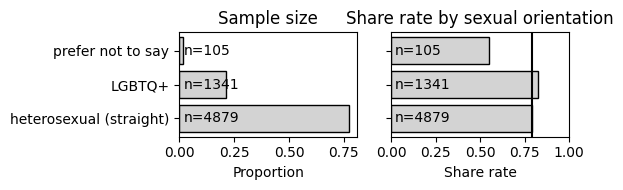

,sexual orientation,n,share rate
0,LGBTQ+,1341,0.828
1,heterosexual (straight),4879,0.790
2,prefer not to say,105,0.552


In [87]:
Q = 'Q-sexual-orientation'
print(fields_df.loc[Q][0])
so_df = df[Q].value_counts().rename('survey N').to_frame()
so_df['survey proportion'] = so_df['survey N']/so_df['survey N'].sum()
figsize = (3, 2)
fig, axes = plt.subplots(1,2,figsize=(figsize[0]*2,figsize[1]), dpi=100, sharey=True)
plt.tight_layout()
plot_survey_proportion_with_N(so_df, axes[0])
axes[0].set_title('Sample size')
colname = 'sexual orientation'
so_share_df = get_share_rate_by_Q_df(Q, colname)
plot_share_by_demo(so_share_df, colname, axes[1])
plt.tight_layout()
plt.show()
so_share_df

#### Evaluate each incentive separately

Q-sexual-orientation
share ~ C(orientation, Treatment(reference='heterosexual (straight)'))
------- control -------
Optimization terminated successfully.
         Current function value: 0.532989
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                          Results: Logit
===================================================================================================================================
Model:                                     Logit                                  Pseudo R-squared:                       0.009    
Dependent Variable:                        share                                  AIC:                                    1365.1213
Date:                                      2023-05-09 14:49                       BIC:                                    1380.5734
No. Observations:                          1275                                   Log-Likelihood:                         -679.56  
Df Model:                                  2                                      LL-Null:                                -686.06  
Df Residuals:                              1272                                   LLR p-value:                            0.0014992
Converged:                                 1.0000                                 Scale:                                  1.0000   
No. Iterations:                            5.0000                                                                                  
-----------------------------------------------------------------------------------------------------------------------------------
                                                                                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                            1.1793   0.0754 15.6415 0.0000  1.0315  1.3271
C(orientation, Treatment(reference='heterosexual (straight)'))[T.LGBTQ+]             0.3203   0.1736  1.8447 0.0651 -0.0200  0.6606
C(orientation, Treatment(reference='heterosexual (straight)'))[T.prefer not to say] -1.2663   0.4242 -2.9854 0.0028 -2.0977 -0.4350
===================================================================================================================================

"""

------- bonus-05 -------
Optimization terminated successfully.
         Current function value: 0.555909
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                          Results: Logit
===================================================================================================================================
Model:                                     Logit                                  Pseudo R-squared:                       0.008    
Dependent Variable:                        share                                  AIC:                                    1412.4489
Date:                                      2023-05-09 14:49                       BIC:                                    1427.8773
No. Observations:                          1265                                   Log-Likelihood:                         -703.22  
Df Model:                                  2                                      LL-Null:                                -708.87  
Df Residuals:                              1262                                   LLR p-value:                            0.0035282
Converged:                                 1.0000                                 Scale:                                  1.0000   
No. Iterations:                            5.0000                                                                                  
-----------------------------------------------------------------------------------------------------------------------------------
                                                                                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                            1.0494   0.0725 14.4788 0.0000  0.9074  1.1915
C(orientation, Treatment(reference='heterosexual (straight)'))[T.LGBTQ+]             0.4169   0.1758  2.3719 0.0177  0.0724  0.7614
C(orientation, Treatment(reference='heterosexual (straight)'))[T.prefer not to say] -1.0494   0.4769 -2.2003 0.0278 -1.9842 -0.1146
===================================================================================================================================

"""

------- bonus-20 -------
Optimization terminated successfully.
         Current function value: 0.497925
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                          Results: Logit
===================================================================================================================================
Model:                                     Logit                                  Pseudo R-squared:                       0.009    
Dependent Variable:                        share                                  AIC:                                    1250.8113
Date:                                      2023-05-09 14:49                       BIC:                                    1266.2040
No. Observations:                          1250                                   Log-Likelihood:                         -622.41  
Df Model:                                  2                                      LL-Null:                                -628.27  
Df Residuals:                              1247                                   LLR p-value:                            0.0028512
Converged:                                 1.0000                                 Scale:                                  1.0000   
No. Iterations:                            5.0000                                                                                  
-----------------------------------------------------------------------------------------------------------------------------------
                                                                                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                            1.3902   0.0802 17.3251 0.0000  1.2329  1.5474
C(orientation, Treatment(reference='heterosexual (straight)'))[T.LGBTQ+]             0.0793   0.1776  0.4466 0.6552 -0.2688  0.4274
C(orientation, Treatment(reference='heterosexual (straight)'))[T.prefer not to say] -1.7956   0.5331 -3.3681 0.0008 -2.8405 -0.7507
===================================================================================================================================

"""

------- bonus-50 -------
Optimization terminated successfully.
         Current function value: 0.406146
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                          Results: Logit
==================================================================================================================================
Model:                                    Logit                                  Pseudo R-squared:                       0.002    
Dependent Variable:                       share                                  AIC:                                    1013.2427
Date:                                     2023-05-09 14:49                       BIC:                                    1028.6113
No. Observations:                         1240                                   Log-Likelihood:                         -503.62  
Df Model:                                 2                                      LL-Null:                                -504.69  
Df Residuals:                             1237                                   LLR p-value:                            0.34362  
Converged:                                1.0000                                 Scale:                                  1.0000   
No. Iterations:                           6.0000                                                                                  
----------------------------------------------------------------------------------------------------------------------------------
                                                                                     Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                            1.8190   0.0935 19.4585 0.0000  1.6357 2.0022
C(orientation, Treatment(reference='heterosexual (straight)'))[T.LGBTQ+]             0.0329   0.2044  0.1608 0.8723 -0.3678 0.4336
C(orientation, Treatment(reference='heterosexual (straight)'))[T.prefer not to say] -0.6738   0.4439 -1.5180 0.1290 -1.5439 0.1962
==================================================================================================================================

"""

------- altruism -------
Optimization terminated successfully.
         Current function value: 0.507514
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                          Results: Logit
===================================================================================================================================
Model:                                     Logit                                  Pseudo R-squared:                       0.009    
Dependent Variable:                        share                                  AIC:                                    1320.4600
Date:                                      2023-05-09 14:49                       BIC:                                    1335.9588
No. Observations:                          1295                                   Log-Likelihood:                         -657.23  
Df Model:                                  2                                      LL-Null:                                -662.98  
Df Residuals:                              1292                                   LLR p-value:                            0.0031783
Converged:                                 1.0000                                 Scale:                                  1.0000   
No. Iterations:                            5.0000                                                                                  
-----------------------------------------------------------------------------------------------------------------------------------
                                                                                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                            1.2984   0.0777 16.7166 0.0000  1.1462  1.4507
C(orientation, Treatment(reference='heterosexual (straight)'))[T.LGBTQ+]             0.2987   0.1749  1.7083 0.0876 -0.0440  0.6414
C(orientation, Treatment(reference='heterosexual (straight)'))[T.prefer not to say] -1.2984   0.4539 -2.8605 0.0042 -2.1881 -0.4088
===================================================================================================================================

"""

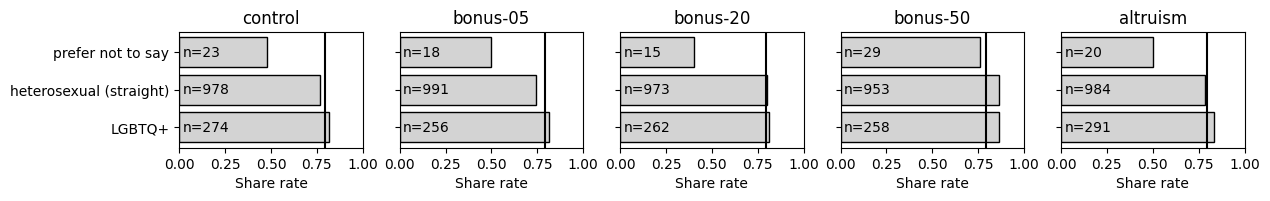

In [88]:
print(Q)
formula = "share ~ C(orientation, Treatment(reference='heterosexual (straight)'))"
print(formula)

figsize = (2.75, 1.5)
# plot horizontally all together
fig, axes = plt.subplots(1,5,figsize=(figsize[0]*5, figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0.2)
for i, incentive in enumerate(incentives_list):
    # restrict data to incentive
    incentive_df = df[df['incentive']==incentive].copy()
    # give demo a short name from Q
    incentive_df['orientation'] = incentive_df[Q]
    print('------- %s -------' % incentive)
    so_share_df = get_share_rate_by_Q_df(Q, colname, df=incentive_df)
    # plot horizontally with the others
    plot_share_by_demo(so_share_df, colname, axes[i])
    axes[i].set_title(incentive)
    model = smf.logit(formula=formula, data=incentive_df).fit()
    display(model.summary2())
    #display(get_predictors_table(model))
    
plt.show()

### By race and hispanic origin

Note the US census and this survey ask about hispanic/latin origin in a question separate from race.

#### Spanish, Hispanic, or Latino origin

Overall

Are you of Spanish, Hispanic, or Latino origin?


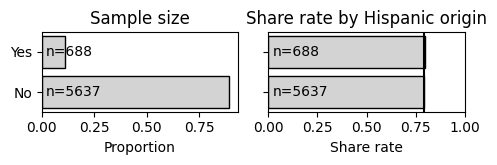

,Hispanic origin,n,share rate
0,No,5637,0.793
1,Yes,688,0.799


In [89]:
Q = 'Q-demos-hispanic'
print(fields_df.loc[Q][0])
hisp_df = df[Q].value_counts().rename('survey N').to_frame()
hisp_df['survey proportion'] = hisp_df['survey N']/hisp_df['survey N'].sum()
figsize = (2.5, 1.75)
fig, axes = plt.subplots(1,2,figsize=(figsize[0]*2,figsize[1]), dpi=100, sharey=True)
plt.tight_layout()
plot_survey_proportion_with_N(hisp_df, axes[0])
axes[0].set_title('Sample size')
colname = 'Hispanic origin'
hisp_share_df = get_share_rate_by_Q_df(Q, colname)
plot_share_by_demo(hisp_share_df, colname, axes[1])
plt.tight_layout()
plt.show()
hisp_share_df

#### Evaluate each incentive separately

Q-demos-hispanic
share ~ C(hispanic)
------- control -------
Optimization terminated successfully.
         Current function value: 0.537982
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:               Logit            Pseudo R-squared: 0.000    
Dependent Variable:  share            AIC:              1375.8552
Date:                2023-05-09 14:49 BIC:              1386.1566
No. Observations:    1275             Log-Likelihood:   -685.93  
Df Model:            1                LL-Null:          -686.06  
Df Residuals:        1273             LLR p-value:      0.60217  
Converged:           1.0000           Scale:            1.0000   
No. Iterations:      5.0000                                      
-----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------
Intercept           1.2263   0.0709 17.2861 0.0000  1.0872 1.3653
C(hispanic)[T.Yes] -0.1088   0.2072 -0.5250 0.5996 -0.5150 0.2974
=================================================================

"""

------- bonus-05 -------
Optimization terminated successfully.
         Current function value: 0.560304
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:               Logit            Pseudo R-squared: 0.000    
Dependent Variable:  share            AIC:              1421.5704
Date:                2023-05-09 14:49 BIC:              1431.8560
No. Observations:    1265             Log-Likelihood:   -708.79  
Df Model:            1                LL-Null:          -708.87  
Df Residuals:        1263             LLR p-value:      0.67797  
Converged:           1.0000           Scale:            1.0000   
No. Iterations:      5.0000                                      
-----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------
Intercept           1.1176   0.0691 16.1759 0.0000  0.9822 1.2530
C(hispanic)[T.Yes] -0.0860   0.2060 -0.4175 0.6763 -0.4898 0.3178
=================================================================

"""

------- bonus-20 -------
Optimization terminated successfully.
         Current function value: 0.502569
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.000    
Dependent Variable: share            AIC:              1260.4222
Date:               2023-05-09 14:49 BIC:              1270.6840
No. Observations:   1250             Log-Likelihood:   -628.21  
Df Model:           1                LL-Null:          -628.27  
Df Residuals:       1248             LLR p-value:      0.74119  
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     5.0000                                      
----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
----------------------------------------------------------------
Intercept          1.3686   0.0742 18.4507 0.0000  1.2232 1.5140
C(hispanic)[T.Yes] 0.0783   0.2387  0.3281 0.7428 -0.3895 0.5461
================================================================

"""

------- bonus-50 -------
Optimization terminated successfully.
         Current function value: 0.406499
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.001    
Dependent Variable: share            AIC:              1012.1170
Date:               2023-05-09 14:49 BIC:              1022.3627
No. Observations:   1240             Log-Likelihood:   -504.06  
Df Model:           1                LL-Null:          -504.69  
Df Residuals:       1238             LLR p-value:      0.26124  
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     6.0000                                      
----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
----------------------------------------------------------------
Intercept          1.7761   0.0852 20.8411 0.0000  1.6091 1.9431
C(hispanic)[T.Yes] 0.3210   0.2957  1.0855 0.2777 -0.2586 0.9007
================================================================

"""

------- altruism -------
Optimization terminated successfully.
         Current function value: 0.511762
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.000    
Dependent Variable: share            AIC:              1329.4630
Date:               2023-05-09 14:49 BIC:              1339.7956
No. Observations:   1295             Log-Likelihood:   -662.73  
Df Model:           1                LL-Null:          -662.98  
Df Residuals:       1293             LLR p-value:      0.47959  
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     5.0000                                      
----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
----------------------------------------------------------------
Intercept          1.3165   0.0725 18.1490 0.0000  1.1743 1.4587
C(hispanic)[T.Yes] 0.1525   0.2184  0.6984 0.4849 -0.2755 0.5805
================================================================

"""

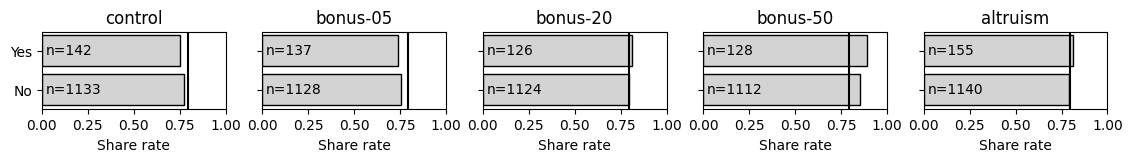

In [93]:
print(Q)
formula = "share ~ C(hispanic)"
print(formula)

figsize = (2.75, 1)
# plot horizontally all together
fig, axes = plt.subplots(1,5,figsize=(figsize[0]*5, figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0.2)
for i, incentive in enumerate(incentives_list):
    # restrict data to incentive
    incentive_df = df[df['incentive']==incentive].copy()
    # give demo a short name from Q
    incentive_df['hispanic'] = incentive_df[Q]
    print('------- %s -------' % incentive)
    hisp_share_df = get_share_rate_by_Q_df(Q, colname, df=incentive_df)
    # plot horizontally with the others
    plot_share_by_demo(hisp_share_df, colname, axes[i])
    axes[i].set_title(incentive)
    model = smf.logit(formula=formula, data=incentive_df).fit()
    display(model.summary2())
    #display(get_predictors_table(model))
    
plt.show()

#### Evaluating Hispanic vs non-Hispanic groups separately

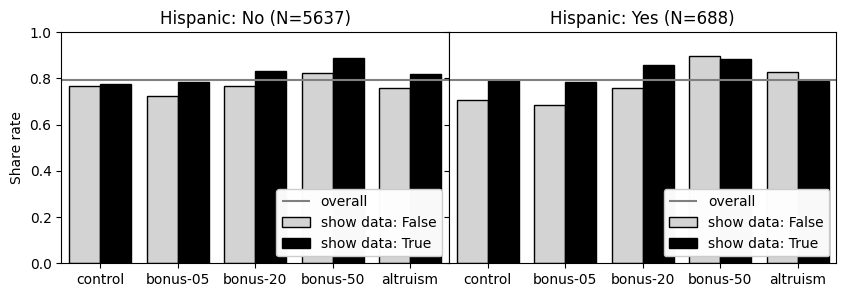

In [96]:
figsize=(5,3)
fig,axes = plt.subplots(1,2,figsize=(figsize[0]*2,figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0)
for i, hisp in enumerate(hisp_df.index.to_list()):
    demo_df = df[df[Q]==hisp]
    demo_agg_share_df = get_aggregate_share_df(demo_df)
    plot_share_rate(demo_agg_share_df, axes[i])
    axes[i].set_title('Hispanic: %s (N=%s)' % (hisp, len(demo_df)))

In [97]:
# Logistic reggressions to test for differences
formula = "share ~ C(incentive, Treatment(reference='control')) + showdata"
for i, hisp in enumerate(hisp_df.index.to_list()):
    print('------- Hispanic origin: %s -------' % hisp)
    print(formula)
    demo_df = df[df[Q]==hisp]
    model = smf.logit(formula=formula, data=demo_df).fit()
    display(model.summary2())
    #display(get_predictors_table(model))

------- Hispanic origin: No -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.503721
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                            Logit                        Pseudo R-squared:             0.011     
Dependent Variable:               share                        AIC:                          5690.9474 
Date:                             2023-05-09 14:57             BIC:                          5730.7700 
No. Observations:                 5637                         Log-Likelihood:               -2839.5   
Df Model:                         5                            LL-Null:                      -2872.1   
Df Residuals:                     5631                         LLR p-value:                  9.7847e-13
Converged:                        1.0000                       Scale:                        1.0000    
No. Iterations:                   6.0000                                                               
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 1.0736   0.0772 13.9051 0.0000  0.9223 1.2249
C(incentive, Treatment(reference='control'))[T.altruism]  0.0879   0.1017  0.8644 0.3873 -0.1114 0.2872
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.1059   0.0993 -1.0669 0.2860 -0.3004 0.0886
C(incentive, Treatment(reference='control'))[T.bonus-20]  0.1485   0.1029  1.4436 0.1488 -0.0531 0.3501
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.5533   0.1111  4.9800 0.0000  0.3355 0.7710
showdata[T.True]                                          0.3221   0.0666  4.8383 0.0000  0.1916 0.4526
=======================================================================================================

"""

------- Hispanic origin: Yes -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.490347
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                            Logit                         Pseudo R-squared:              0.022   
Dependent Variable:               share                         AIC:                           686.7180
Date:                             2023-05-09 14:57              BIC:                           713.9207
No. Observations:                 688                           Log-Likelihood:                -337.36 
Df Model:                         5                             LL-Null:                       -344.83 
Df Residuals:                     682                           LLR p-value:                   0.010607
Converged:                        1.0000                        Scale:                         1.0000  
No. Iterations:                   6.0000                                                               
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 0.9681   0.2184  4.4337 0.0000  0.5401 1.3961
C(incentive, Treatment(reference='control'))[T.altruism]  0.3840   0.2848  1.3481 0.1776 -0.1743 0.9422
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.0773   0.2755 -0.2804 0.7792 -0.6173 0.4628
C(incentive, Treatment(reference='control'))[T.bonus-20]  0.3404   0.2996  1.1362 0.2559 -0.2468 0.9276
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.9834   0.3442  2.8574 0.0043  0.3088 1.6579
showdata[T.True]                                          0.2849   0.1936  1.4712 0.1412 -0.0946 0.6644
=======================================================================================================

"""

### Race

In [98]:
Q = 'Q-demos-race'
print(fields_df.loc[Q][0])
race_df = df[Q].value_counts().rename('survey N').to_frame()
race_df['survey proportion'] = round(race_df['survey N']/race_df['survey N'].sum(), 3)
race_df.head(10)

Choose one or more races that you consider yourself to be


,survey N,survey proportion
Q-demos-race,,
White or Caucasian,4825,0.763
Asian,551,0.087
Black or African American,440,0.070
Other,134,0.021
"White or Caucasian,Asian",96,0.015
"White or Caucasian,Black or African American",72,0.011
"White or Caucasian,American Indian/Native American or Alaska Native",66,0.010
American Indian/Native American or Alaska Native,38,0.006
"White or Caucasian,Other",32,0.005


For simplicity we aggregate 'Other' + anyone who answered 2 more more races

Note this is very simplifying.

In [114]:
df['race'] = df[Q].apply(lambda r: 'Other or 2 or more races' if ((len(r.split(',')) > 1) or ('Other' in r)) else r)
race_df = df['race'].value_counts().rename('survey N').to_frame()
race_df['survey proportion'] = round(race_df['survey N']/race_df['survey N'].sum(), 3)
race_df.head(10)

,survey N,survey proportion
race,,
White or Caucasian,4825,0.763
Asian,551,0.087
Other or 2 or more races,471,0.074
Black or African American,440,0.070
American Indian/Native American or Alaska Native,38,0.006


Overall

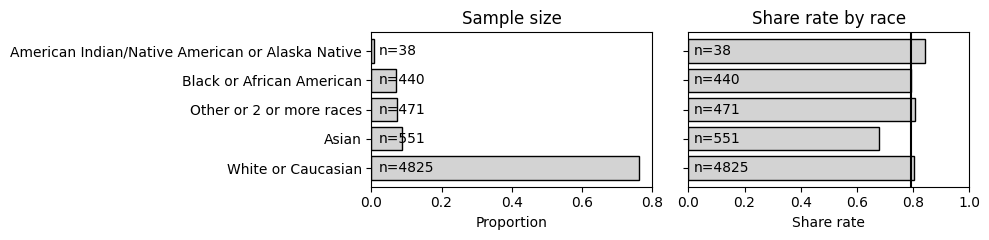

,race,n,share rate
0,American Indian/Native American or Alaska Native,38,0.842
1,Asian,551,0.679
2,Black or African American,440,0.795
3,Other or 2 or more races,471,0.809
4,White or Caucasian,4825,0.805


In [118]:
figsize = (5, 2.5)
fig, axes = plt.subplots(1,2,figsize=(figsize[0]*2,figsize[1]), dpi=100, sharey=True)
plt.tight_layout()
plot_survey_proportion_with_N(race_df, axes[0])
axes[0].set_title('Sample size')
colname = 'race'
race_share_df = get_share_rate_by_Q_df('race', colname)
plot_share_by_demo(race_share_df, colname, axes[1])
plt.tight_layout()
plt.show()
race_share_df

#### Evaluate each incentive separately

share ~ C(race, Treatment(reference='White or Caucasian'))
------- control -------
         Current function value: 0.533303
         Iterations: 35


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                       Results: Logit
============================================================================================================================================================
Model:                                              Logit                                          Pseudo R-squared:                               0.009    
Dependent Variable:                                 share                                          AIC:                                            1369.9232
Date:                                               2023-05-09 15:17                               BIC:                                            1395.6767
No. Observations:                                   1275                                           Log-Likelihood:                                 -679.96  
Df Model:                                           4                                              LL-Null:                                        -686.06  
Df Residuals:                                       1270                                           LLR p-value:                                    0.015899 
Converged:                                          0.0000                                         Scale:                                          1.0000   
No. Iterations:                                     35.0000                                                                                                 
------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                        Coef.   Std.Err.    z    P>|z|    [0.025     0.975] 
------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                               1.2777    0.0782 16.3357 0.0000     1.1244    1.4310
C(race, Treatment(reference='White or Caucasian'))[T.American Indian/Native American or Alaska Native] 15.8738 2164.3699  0.0073 0.9941 -4226.2133 4257.9609
C(race, Treatment(reference='White or Caucasian'))[T.Asian]                                            -0.6346    0.2082 -3.0487 0.0023    -1.0426   -0.2266
C(race, Treatment(reference='White or Caucasian'))[T.Black or African American]                         0.0573    0.2632  0.2176 0.8278    -0.4586    0.5731
C(race, Treatment(reference='White or Caucasian'))[T.Other or 2 or more races]                         -0.0783    0.2555 -0.3066 0.7592    -0.5791    0.4224
============================================================================================================================================================

"""

------- bonus-05 -------
Optimization terminated successfully.
         Current function value: 0.558800
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                   Results: Logit
=====================================================================================================================================================
Model:                                           Logit                                        Pseudo R-squared:                             0.003    
Dependent Variable:                              share                                        AIC:                                          1423.7630
Date:                                            2023-05-09 15:17                             BIC:                                          1449.4771
No. Observations:                                1265                                         Log-Likelihood:                               -706.88  
Df Model:                                        4                                            LL-Null:                                      -708.87  
Df Residuals:                                    1260                                         LLR p-value:                                  0.40875  
Converged:                                       1.0000                                       Scale:                                        1.0000   
No. Iterations:                                  5.0000                                                                                              
-----------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                        Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                               1.1381   0.0742 15.3437 0.0000  0.9927 1.2835
C(race, Treatment(reference='White or Caucasian'))[T.American Indian/Native American or Alaska Native] -0.4450   0.7110 -0.6258 0.5314 -1.8385 0.9486
C(race, Treatment(reference='White or Caucasian'))[T.Asian]                                            -0.4005   0.2243 -1.7858 0.0741 -0.8401 0.0391
C(race, Treatment(reference='White or Caucasian'))[T.Black or African American]                         0.1718   0.2832  0.6067 0.5440 -0.3832 0.7269
C(race, Treatment(reference='White or Caucasian'))[T.Other or 2 or more races]                         -0.0237   0.2622 -0.0905 0.9279 -0.5376 0.4902
=====================================================================================================================================================

"""

------- bonus-20 -------
Optimization terminated successfully.
         Current function value: 0.498810
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                    Results: Logit
======================================================================================================================================================
Model:                                            Logit                                        Pseudo R-squared:                             0.008    
Dependent Variable:                               share                                        AIC:                                          1257.0245
Date:                                             2023-05-09 15:17                             BIC:                                          1282.6790
No. Observations:                                 1250                                         Log-Likelihood:                               -623.51  
Df Model:                                         4                                            LL-Null:                                      -628.27  
Df Residuals:                                     1245                                         LLR p-value:                                  0.049608 
Converged:                                        1.0000                                       Scale:                                        1.0000   
No. Iterations:                                   6.0000                                                                                              
------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                               1.4706   0.0829 17.7425 0.0000  1.3082  1.6331
C(race, Treatment(reference='White or Caucasian'))[T.American Indian/Native American or Alaska Native]  0.6088   1.0639  0.5723 0.5672 -1.4764  2.6940
C(race, Treatment(reference='White or Caucasian'))[T.Asian]                                            -0.6721   0.2461 -2.7309 0.0063 -1.1545 -0.1897
C(race, Treatment(reference='White or Caucasian'))[T.Black or African American]                        -0.0843   0.2634 -0.3202 0.7488 -0.6006  0.4319
C(race, Treatment(reference='White or Caucasian'))[T.Other or 2 or more races]                         -0.4268   0.2469 -1.7288 0.0838 -0.9107  0.0571
======================================================================================================================================================

"""

------- bonus-50 -------
         Current function value: 0.398455
         Iterations: 35


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                        Results: Logit
===============================================================================================================================================================
Model:                                              Logit                                           Pseudo R-squared:                                0.021     
Dependent Variable:                                 share                                           AIC:                                             998.1679  
Date:                                               2023-05-09 15:17                                BIC:                                             1023.7822 
No. Observations:                                   1240                                            Log-Likelihood:                                  -494.08   
Df Model:                                           4                                               LL-Null:                                         -504.69   
Df Residuals:                                       1235                                            LLR p-value:                                     0.00028754
Converged:                                          0.0000                                          Scale:                                           1.0000    
No. Iterations:                                     35.0000                                                                                                    
---------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                        Coef.   Std.Err.     z    P>|z|     [0.025     0.975]  
---------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                               1.9398     0.0989 19.6193 0.0000      1.7460     2.1336
C(race, Treatment(reference='White or Caucasian'))[T.American Indian/Native American or Alaska Native] 18.9502 10869.5049  0.0017 0.9986 -21284.8880 21322.7885
C(race, Treatment(reference='White or Caucasian'))[T.Asian]                                            -1.0175     0.2283 -4.4564 0.0000     -1.4649    -0.5700
C(race, Treatment(reference='White or Caucasian'))[T.Black or African American]                        -0.2143     0.3169 -0.6763 0.4989     -0.8353     0.4067
C(race, Treatment(reference='White or Caucasian'))[T.Other or 2 or more races]                          0.0180     0.3238  0.0555 0.9558     -0.6168     0.6527
===============================================================================================================================================================

"""

------- altruism -------
Optimization terminated successfully.
         Current function value: 0.503115
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                    Results: Logit
======================================================================================================================================================
Model:                                           Logit                                        Pseudo R-squared:                             0.017     
Dependent Variable:                              share                                        AIC:                                          1313.0684 
Date:                                            2023-05-09 15:17                             BIC:                                          1338.8997 
No. Observations:                                1295                                         Log-Likelihood:                               -651.53   
Df Model:                                        4                                            LL-Null:                                      -662.98   
Df Residuals:                                    1290                                         LLR p-value:                                  0.00013292
Converged:                                       1.0000                                       Scale:                                        1.0000    
No. Iterations:                                  6.0000                                                                                               
------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                               1.4028   0.0799 17.5501 0.0000  1.2462  1.5595
C(race, Treatment(reference='White or Caucasian'))[T.American Indian/Native American or Alaska Native] -1.4028   1.0032 -1.3984 0.1620 -3.3690  0.5634
C(race, Treatment(reference='White or Caucasian'))[T.Asian]                                            -0.7332   0.2038 -3.5970 0.0003 -1.1327 -0.3337
C(race, Treatment(reference='White or Caucasian'))[T.Black or African American]                        -0.3381   0.2713 -1.2460 0.2127 -0.8699  0.1937
C(race, Treatment(reference='White or Caucasian'))[T.Other or 2 or more races]                          0.7719   0.3432  2.2495 0.0245  0.0994  1.4445
======================================================================================================================================================

"""

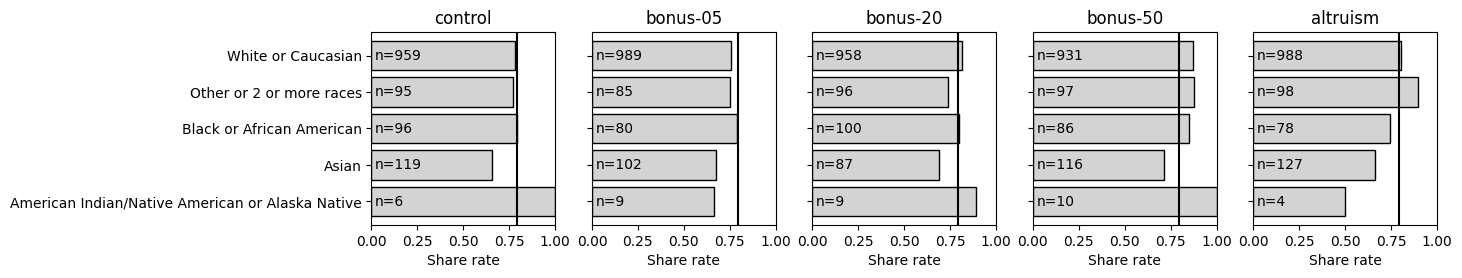

In [119]:
formula = "share ~ C(race, Treatment(reference='White or Caucasian'))"
print(formula)
figsize = (2.75, 2.5)
# plot horizontally all together
fig, axes = plt.subplots(1,5,figsize=(figsize[0]*5, figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0.2)
for i, incentive in enumerate(incentives_list):
    # restrict data to incentive
    incentive_df = df[df['incentive']==incentive].copy()
    # give demo a short name from Q
    print('------- %s -------' % incentive)
    race_share_df = get_share_rate_by_Q_df('race', colname, df=incentive_df)
    # plot horizontally with the others
    plot_share_by_demo(race_share_df, colname, axes[i])
    axes[i].set_title(incentive)
    model = smf.logit(formula=formula, data=incentive_df).fit()
    display(model.summary2())
    #display(get_predictors_table(model))
    
plt.show()

#### Evaluating by racial groups separately

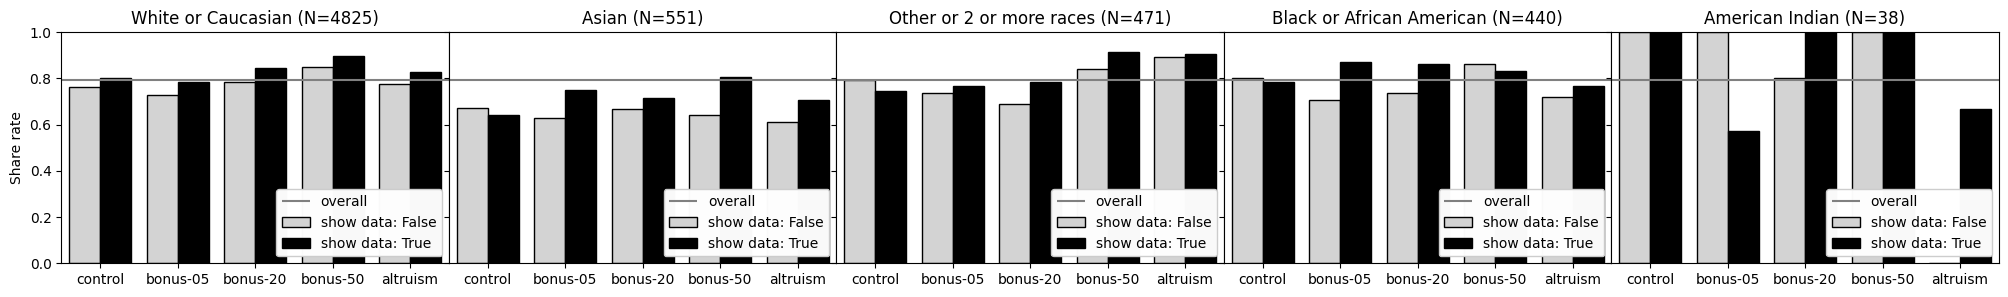

In [124]:
figsize=(5,3)
fig,axes = plt.subplots(1,5,figsize=(figsize[0]*5,figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0)
for i, race in enumerate(race_df.index.to_list()):
    demo_df = df[df['race']==race]
    demo_agg_share_df = get_aggregate_share_df(demo_df)
    plot_share_rate(demo_agg_share_df, axes[i])
    axes[i].set_title('%s (N=%s)' % (race.split('/')[0], len(demo_df)))

In [126]:
# Logistic reggressions to test for differences
formula = "share ~ C(incentive, Treatment(reference='control')) + showdata"
for i, race in enumerate(race_df.index.to_list()):
    if 'American Indian' in race: # Group too small
        continue
    print('------- race group: %s -------' % race)
    print(formula)
    demo_df = df[df['race']==race]
    model = smf.logit(formula=formula, data=demo_df).fit()
    display(model.summary2())
    #display(get_predictors_table(model))

------- race group: White or Caucasian -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.486061
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                            Logit                        Pseudo R-squared:             0.014     
Dependent Variable:               share                        AIC:                          4702.4888 
Date:                             2023-05-09 15:27             BIC:                          4741.3782 
No. Observations:                 4825                         Log-Likelihood:               -2345.2   
Df Model:                         5                            LL-Null:                      -2379.4   
Df Residuals:                     4819                         LLR p-value:                  2.3524e-13
Converged:                        1.0000                       Scale:                        1.0000    
No. Iterations:                   6.0000                                                               
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 1.1251   0.0851 13.2249 0.0000  0.9583 1.2918
C(incentive, Treatment(reference='control'))[T.altruism]  0.1241   0.1121  1.1072 0.2682 -0.0956 0.3438
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.1403   0.1080 -1.2989 0.1940 -0.3521 0.0714
C(incentive, Treatment(reference='control'))[T.bonus-20]  0.2003   0.1142  1.7533 0.0795 -0.0236 0.4241
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.6607   0.1263  5.2316 0.0000  0.4132 0.9082
showdata[T.True]                                          0.3238   0.0737  4.3954 0.0000  0.1794 0.4682
=======================================================================================================

"""

------- race group: Asian -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.623052
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                           Results: Logit
=====================================================================================================
Model:                            Logit                        Pseudo R-squared:             0.008   
Dependent Variable:               share                        AIC:                          698.6036
Date:                             2023-05-09 15:27             BIC:                          724.4740
No. Observations:                 551                          Log-Likelihood:               -343.30 
Df Model:                         5                            LL-Null:                      -345.92 
Df Residuals:                     545                          LLR p-value:                  0.38872 
Converged:                        1.0000                       Scale:                        1.0000  
No. Iterations:                   5.0000                                                             
-----------------------------------------------------------------------------------------------------
                                                         Coef.  Std.Err.   z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------------------------------------------
Intercept                                                0.4502   0.2155 2.0891 0.0367  0.0278 0.8725
C(incentive, Treatment(reference='control'))[T.altruism] 0.0363   0.2701 0.1345 0.8930 -0.4930 0.5657
C(incentive, Treatment(reference='control'))[T.bonus-05] 0.1488   0.2887 0.5153 0.6064 -0.4171 0.7147
C(incentive, Treatment(reference='control'))[T.bonus-20] 0.1769   0.3029 0.5842 0.5591 -0.4167 0.7705
C(incentive, Treatment(reference='control'))[T.bonus-50] 0.3143   0.2837 1.1078 0.2680 -0.2418 0.8703
showdata[T.True]                                         0.3684   0.1855 1.9862 0.0470  0.0049 0.7320
=====================================================================================================

"""

------- race group: Other or 2 or more races -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.471670
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                           Logit                         Pseudo R-squared:              0.033    
Dependent Variable:              share                         AIC:                           456.3135 
Date:                            2023-05-09 15:27              BIC:                           481.2426 
No. Observations:                471                           Log-Likelihood:                -222.16  
Df Model:                        5                             LL-Null:                       -229.75  
Df Residuals:                    465                           LLR p-value:                   0.0096045
Converged:                       1.0000                        Scale:                         1.0000   
No. Iterations:                  6.0000                                                                
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 1.0931   0.2677  4.0832 0.0000  0.5684 1.6178
C(incentive, Treatment(reference='control'))[T.altruism]  0.9915   0.4137  2.3967 0.0165  0.1807 1.8022
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.0877   0.3503 -0.2504 0.8023 -0.7742 0.5988
C(incentive, Treatment(reference='control'))[T.bonus-20] -0.1641   0.3370 -0.4868 0.6264 -0.8246 0.4965
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.7619   0.3931  1.9381 0.0526 -0.0086 1.5324
showdata[T.True]                                          0.2216   0.2393  0.9259 0.3545 -0.2475 0.6906
=======================================================================================================

"""

------- race group: Black or African American -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.500678
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                            Logit                         Pseudo R-squared:              0.012   
Dependent Variable:               share                         AIC:                           452.5969
Date:                             2023-05-09 15:27              BIC:                           477.1175
No. Observations:                 440                           Log-Likelihood:                -220.30 
Df Model:                         5                             LL-Null:                       -222.92 
Df Residuals:                     434                           LLR p-value:                   0.38661 
Converged:                        1.0000                        Scale:                         1.0000  
No. Iterations:                   6.0000                                                               
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 1.1505   0.2767  4.1578 0.0000  0.6082 1.6929
C(incentive, Treatment(reference='control'))[T.altruism] -0.2604   0.3622 -0.7190 0.4722 -0.9704 0.4495
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.0092   0.3725 -0.0247 0.9803 -0.7392 0.7208
C(incentive, Treatment(reference='control'))[T.bonus-20]  0.0594   0.3555  0.1670 0.8674 -0.6374 0.7561
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.4081   0.3933  1.0377 0.2994 -0.3627 1.1789
showdata[T.True]                                          0.3655   0.2391  1.5288 0.1263 -0.1031 0.8340
=======================================================================================================

"""